# Neural Signal Compression for Brain Computer Interfaces

Neuralink, US Patent No. 2023/0284982 A1, Filed 3/9/2022, Published 9/14/2023

Notebook written by Michael Zhou (mgz2112@columbia.edu)

## Background

- **Neural signal compression** is a technique used for **transmitting and processing neural data**
- Gathering/transmitting data as a whole wirelessly leads to **excess information overflow**, which **increases latency/delay** of signal transmission. 
- **Data compression** solves this problem by preventing overflow/latency issues, reduces size and space, improving overall system performance. 

## Goal

This notebook provides an implementation of the 4 neural signal compression algorithms described in US patent application number US 2023/0284982 by Neuralink, titled "Neural Signal Compression for Brain Computer Interfaces".

The 4 compression algorithms include:
- <font color='blue'>**Lossless** compression</font> 
- <font color='red'>**Lossy** compression</font> 
- <font color='green'>**Sparse** compression: **Binned-Spike** mode</font> 
- <font color='green'>**Sparse** compression: **Spike-Band** mode</font> 

In [1085]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats
import pandas as pd
from tqdm import tqdm
import zlib
import struct
import pywt
import array
import fractions
import random

## Neural Transmitter - Overall Signal Flowchart
![alt text](Flowchart.png)

## <font color='blue'> Lossless Compression </font> 

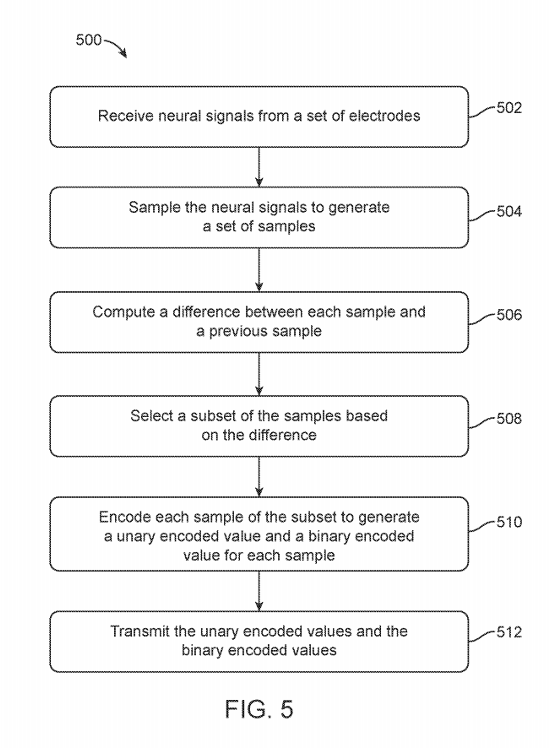

### 1. Receive Signal

Receive neural signals from electrodes. 

Since we do not have the actual equipment, let's generate a (simulated) neural signal. 

In [1086]:
fs = 20000
T = 2

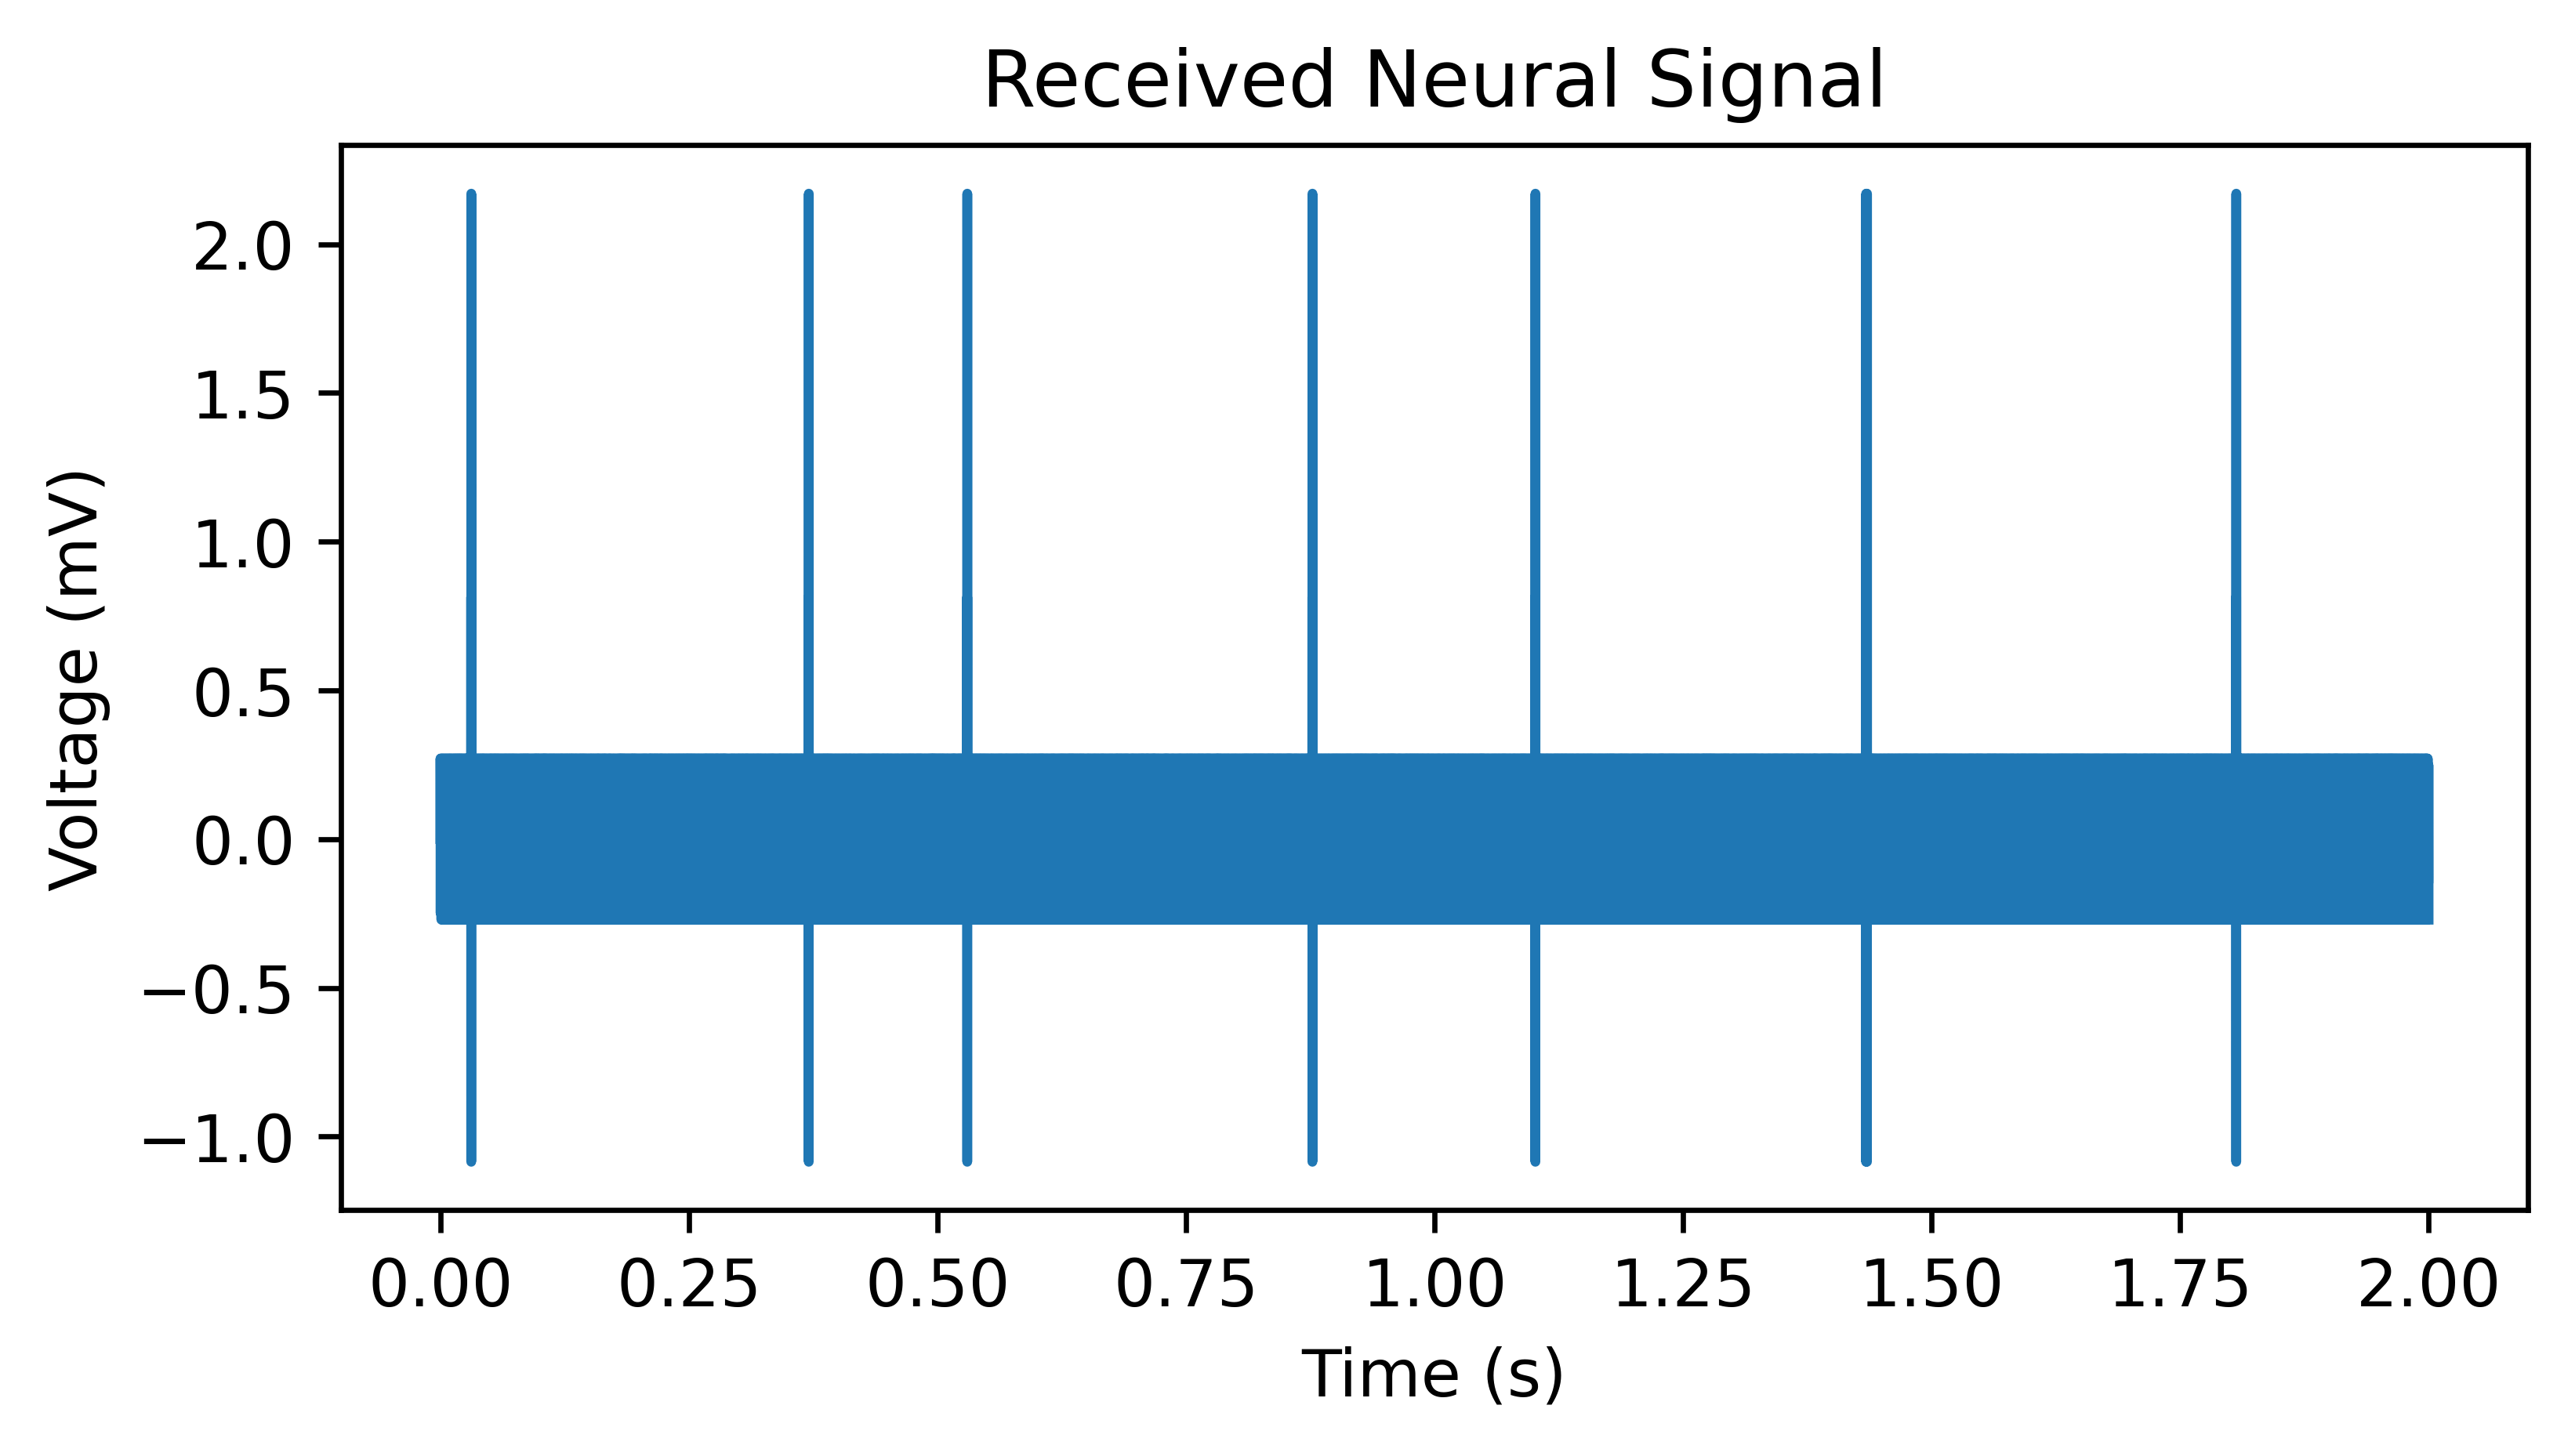

In [1087]:
%run sampler.ipynb 

sampler = Sampler(fs, T, n_spikes=8)
t = sampler.t
x = sampler.sample()

### 2. Generate Set of Samples (that correspond to spikes)

Detect spikes in the signal. 

Refer to the [notebook](https://github.com/michaela10c/neural_spike_detection/) for US patent 2021/0012909 A1, "Real-Time Neural Spike Detection". 

The patent mentions **two operation modes**: **broadband** and **spike-snippets**. To save computational resources and memory, let's use the **spike-snippets** mode (only take the samples that revolve around a spike). 

### Detect spikes:

In [1088]:
blackout_period = 0.04

In [1089]:
# Used for MAD + threshold calculations
alpha=0.0002
beta=3.75

In [1090]:
# Set threshold values here
MAX_ASYM = 4
MIN_RATIO = 1.01
MAX_COST = 2
MIN_THRES = -0.004
MAX_THRES = 0.002
MAX_LDIST = 0.1
MIN_RDIST = 5e-5
MAX_RDIST = 0.1

<Figure size 432x288 with 0 Axes>

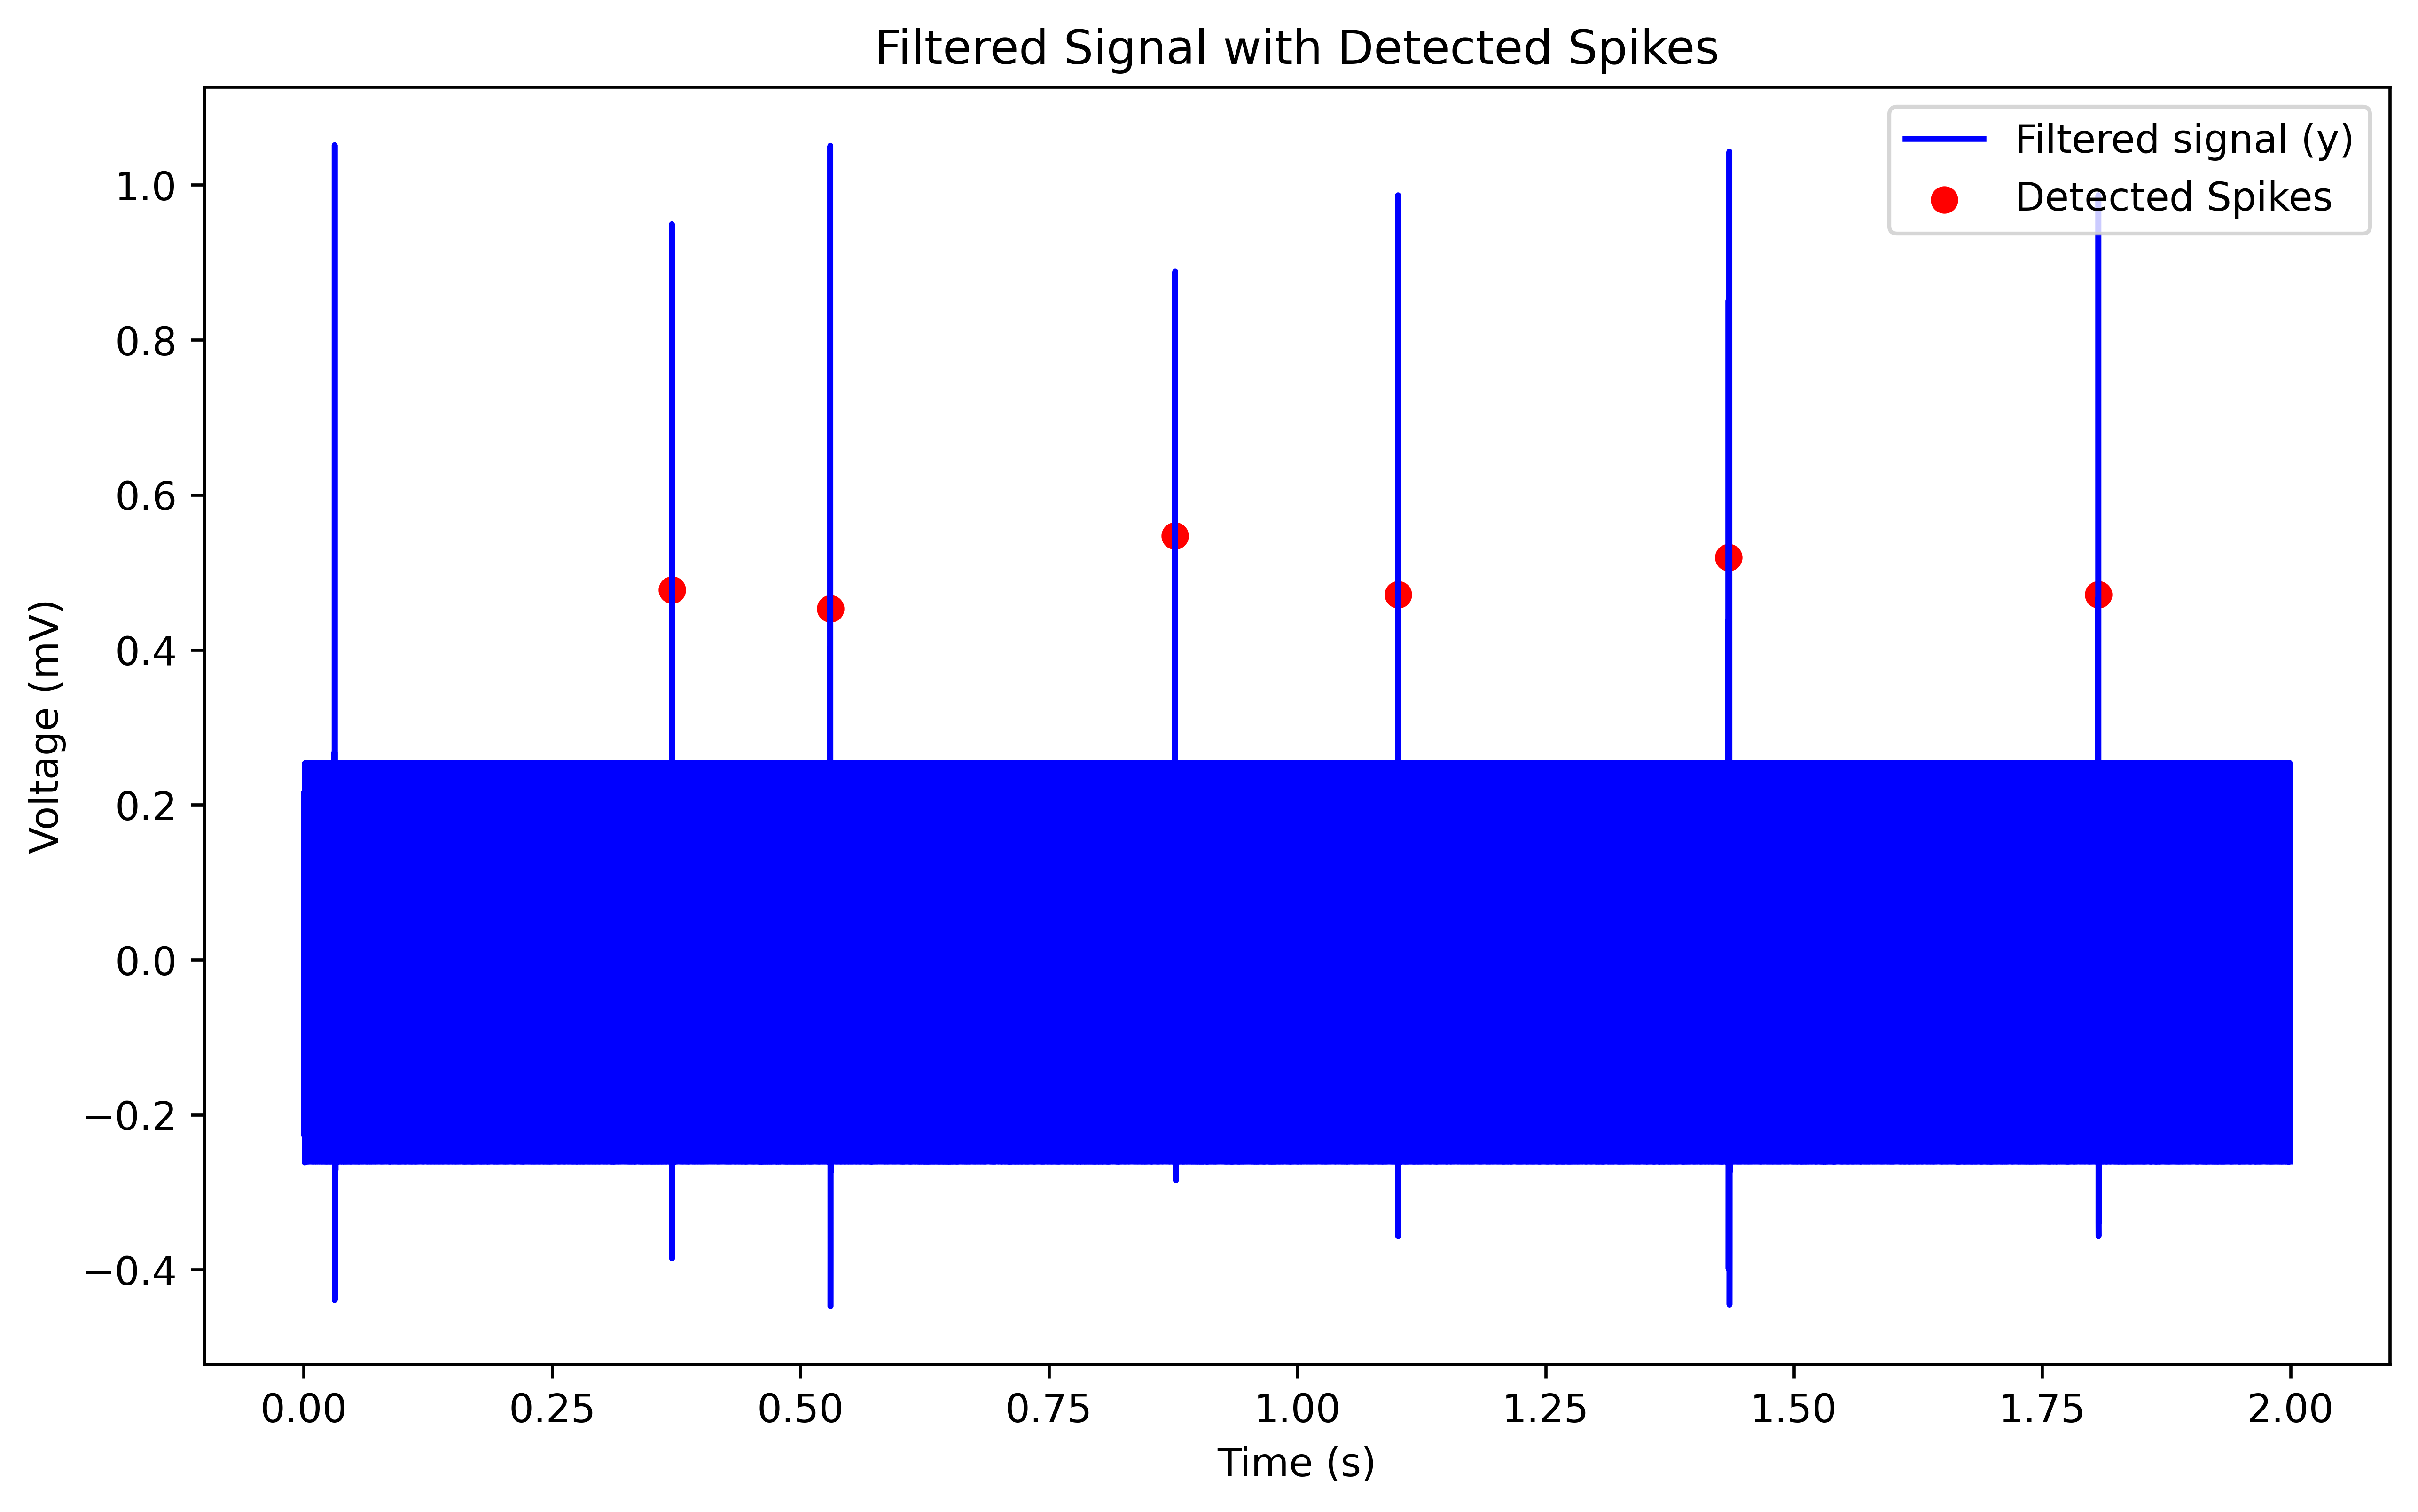

In [1091]:
%run spike_detector.ipynb 

spike_detector = SpikeDetector(x, t, 
                               fs, 
                               blackout_period = blackout_period,
                               alpha = alpha,
                               beta = beta,
                               MIN_RATIO = MIN_RATIO,
                               MAX_ASYM = MAX_ASYM,
                               MAX_COST = MAX_COST,
                               MIN_THRES = MIN_THRES,
                               MAX_THRES = MAX_THRES,
                               MAX_LDIST = MAX_LDIST,
                               MIN_RDIST = MIN_RDIST,
                               MAX_RDIST = MAX_RDIST
                              )
spikes = spike_detector.detect()
spike_detector.plot_spikes(spikes)
df = spike_detector.spikes_dataframe(spikes)

### Spike-Snippet Mode: Take Snippets of Samples that Revolve around Spikes

In [1092]:
x = spike_detector.x
t = spike_detector.t
spike_times = np.array([spike[1]['rp'] for spike in spikes])

In [1093]:
# Converts time t (in seconds) to index in data
def time_to_index(t):
    return int(t * fs)

In [1094]:
def get_signal_snippets(x, t, spike_times, window_size=5):
    """
    Get snippets of the original signal centered around spike_times with a specific window size
    
    params:
    - signal: original signal
    - spike_times: times of each spike
    - window_size: length of window from point center
    
    Return:
    - snippets: snippets of the original signal
    """
    # Convert detected spike times to indices
    f = np.vectorize(time_to_index)
    spike_indices = f(spike_times)
    
    # Return the snippets centered around the spike indices with intervals: [point - window_size, point + window_size]
    snippets = np.array([x[point - window_size : point + window_size] for point in spike_indices])
    snippet_times = np.array([t[point - window_size : point + window_size] for point in spike_indices])
    return snippets, snippet_times

snippets, snippet_times = get_signal_snippets(x, t, spike_times, window_size=5)

In [1095]:
# Convert snippet times to indices
f = np.vectorize(time_to_index)
snippet_indices = f(snippet_times).ravel()

In [1096]:
# Make a copy of x first
x_snippets = np.copy(x)

# For all signals that are not part of the spike-snippets, set its value to zero.
for i in range(len(t)):
    if i not in snippet_indices:
        x_snippets[i] = 0

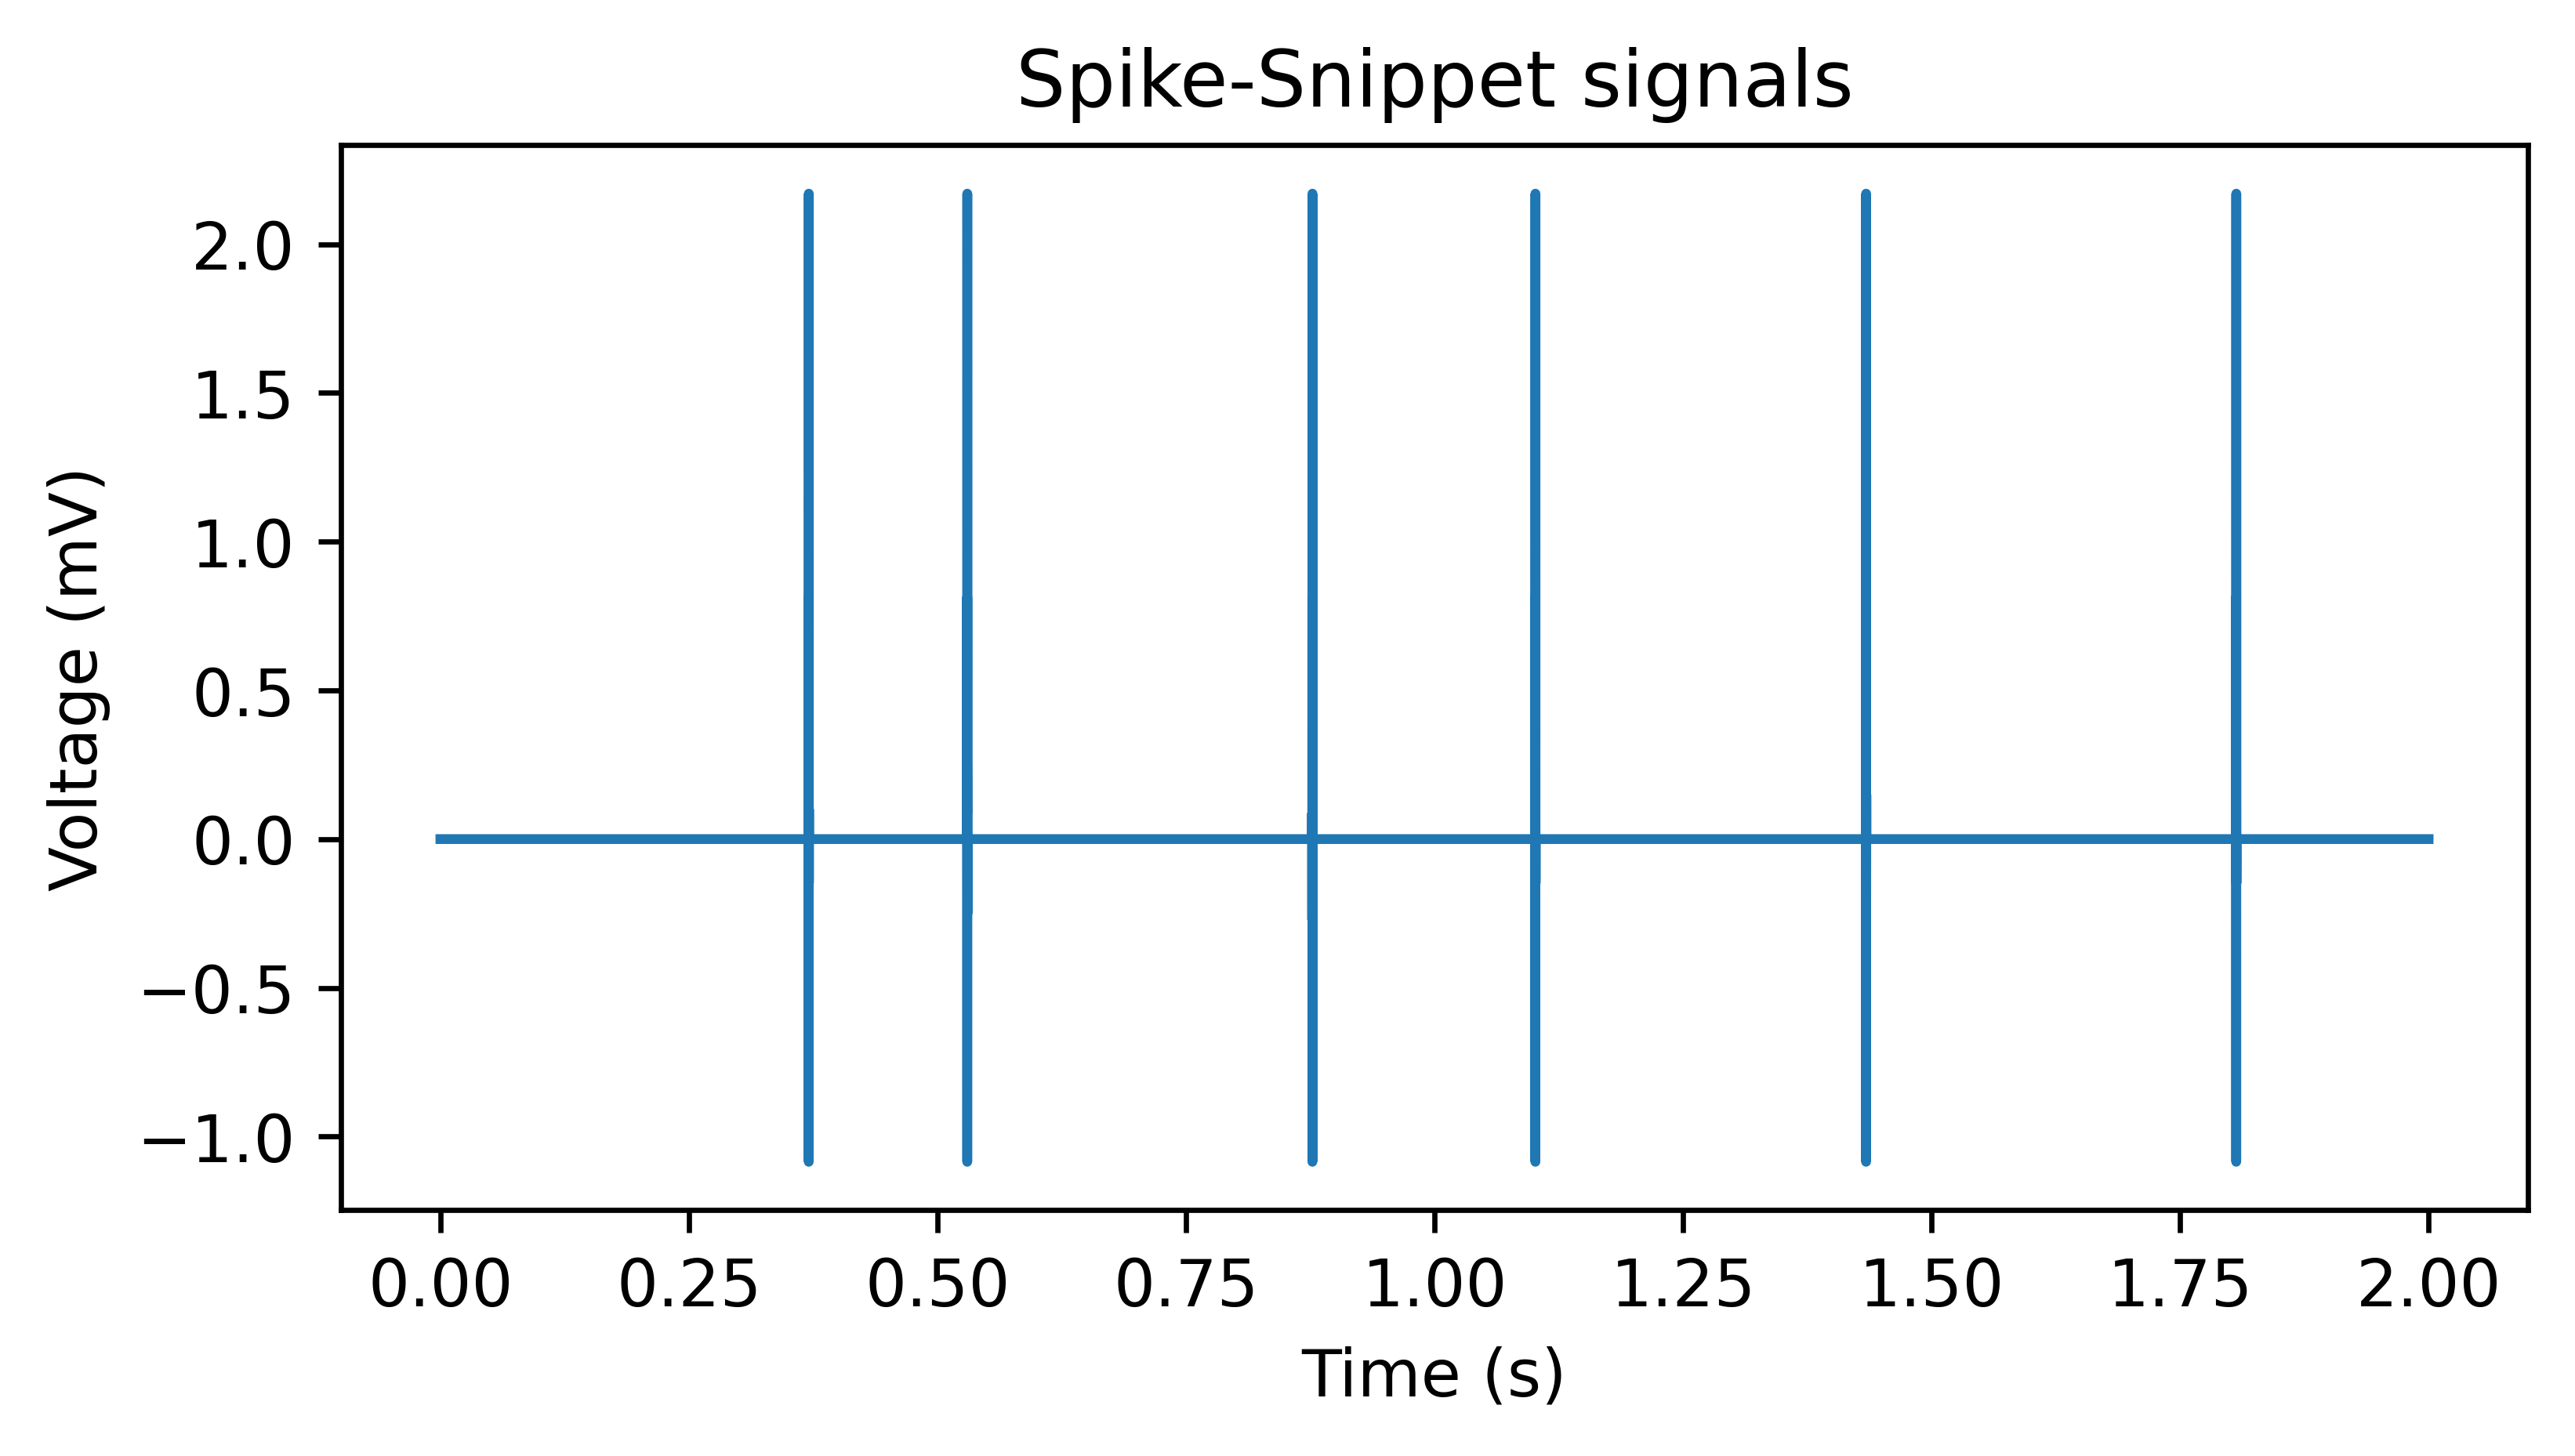

In [1097]:
# Plot the spike-snippet signals
fig, ax = plt.subplots(1, 1, figsize=(6, 3),dpi = 600)

plt.title("Spike-Snippet signals")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (s)")

plt.plot(t, x_snippets)
plt.show()

### 3. Compute Differences between Samples

The differences between samples can be represented as: 

$y[n] = x[n] - x[n - 1]$, 

where $n$ is the index of a signal, and $x$ is the original signal. 

In [1098]:
# Compute differences between samples
diff = np.diff(x_snippets)

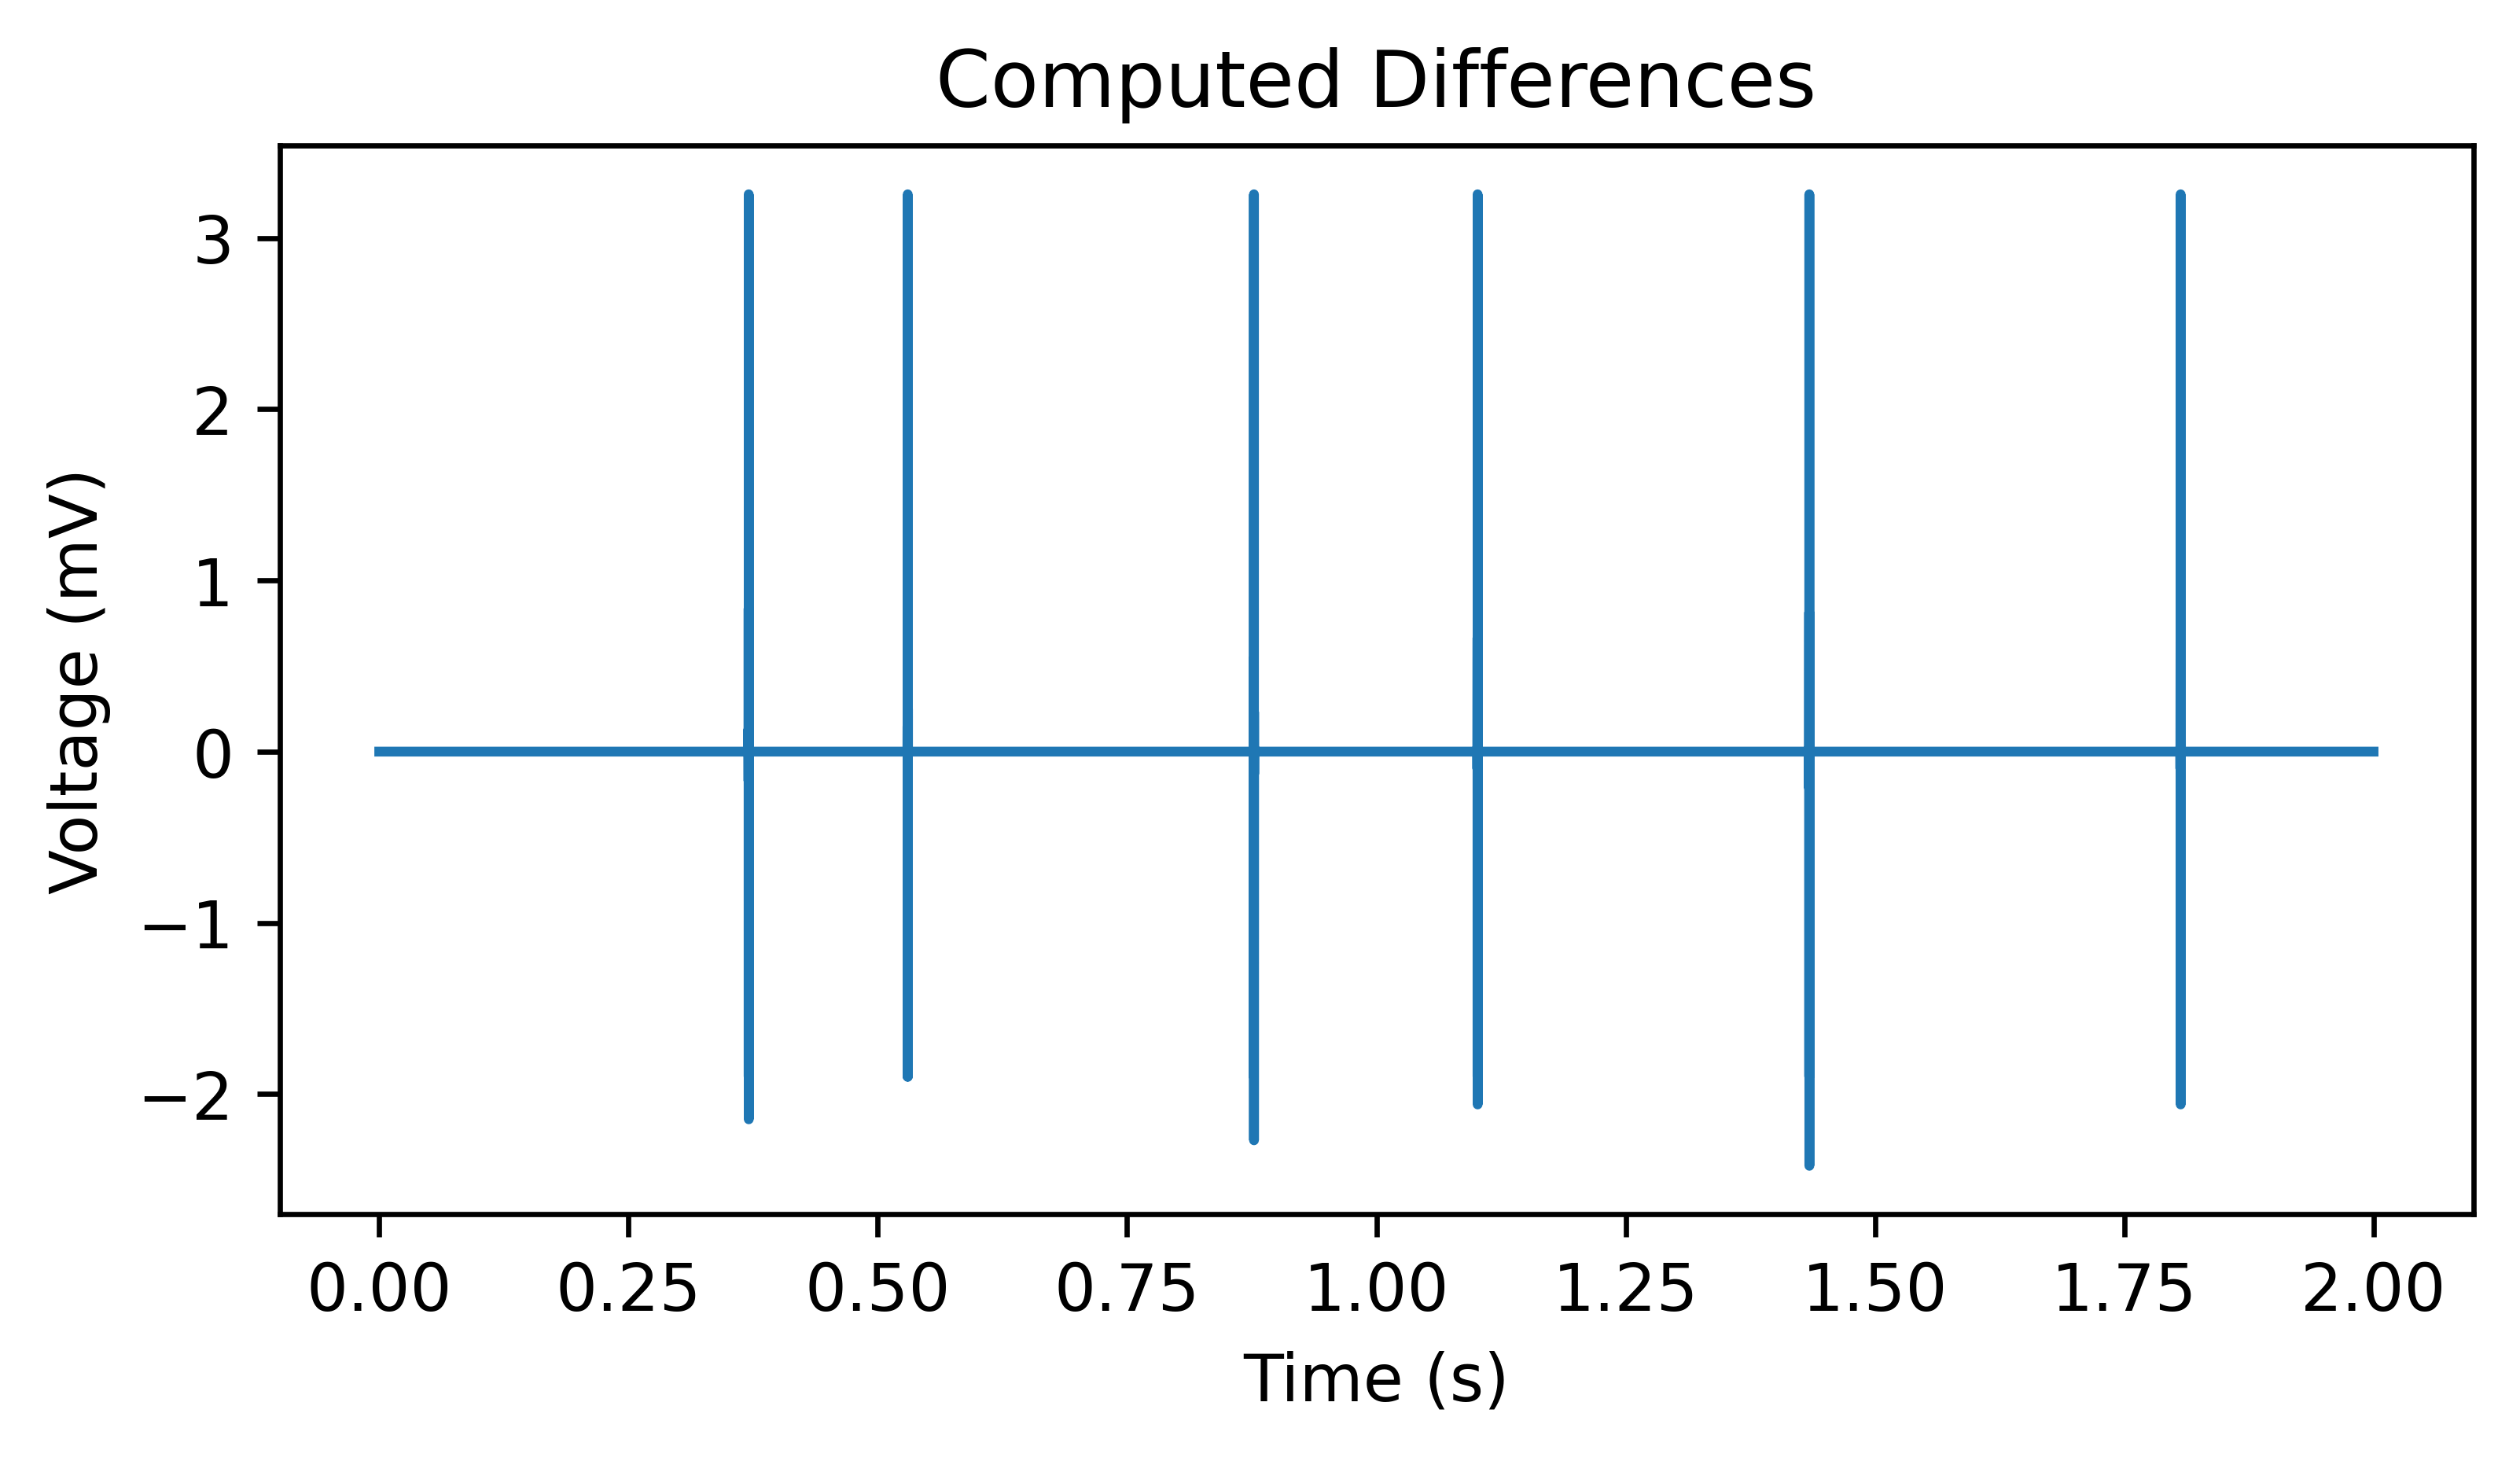

In [1099]:
# Plot the computed differences
fig, ax = plt.subplots(1, 1, figsize=(6, 3),dpi = 600)

plt.title("Computed Differences")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (s)")

plt.plot(t[1:], diff)
plt.show()

### 4. Identify Subset of Values (with Non-Zero Difference)

To reduce duplicative data, as well as the size per symbol, we only sample a ***subset*** of samples, specifically those that have **non-zero difference**. 

In [1100]:
# Take the subset with non-zero differences
subset_indices = np.where(diff > 0)[0]
diff_subset = diff[subset_indices]
t_subset = t[subset_indices]
x_subset = x_snippets[subset_indices]

In [1101]:
# Do not use scientific notation
np.set_printoptions(suppress=True)

In [1102]:
print('Subset of values with non-zero difference:\n', x_subset)

Subset of values with non-zero difference:
 [ 0.          0.13142952 -0.02248952 -1.08505519 -0.14851756 -0.13140182
  0.          0.09999524  0.08671021 -1.08505519 -0.24886676  0.
 -0.27113024  0.00000829  0.27117403 -1.08505519 -0.09998607 -0.10013481
  0.13136763  0.14845838 -1.08505519 -0.1484564  -0.13135663 -0.27113672
 -0.00002814 -1.08505519 -0.248966   -0.09992319  0.13142822 -0.0999755
  0.13138779  0.14843697 -1.08505519 -0.14841505 -0.13140834]


### 5. Generate Unary & Binary-Encoded Value (via Rice-Golomb Encoding)

Compute a **factor** (e.g., entropy measure of samples) that **minimizes total size** of each **encoded sample**. 

To achieve a **high-compression ratio** with **low computational cost** (**minimal space & power usage**), we choose **Rice-Golomb encoding** as our encoding method. 

**Rice-Golomb encoding**: 

Based on the computed factor, compute a **quotient ($Q$, unary)** and **remainder ($R$, binary)**

$S = Q \times M + R$

$Q = [\frac{X}{M}]$ (encoded by [**unary encoding**](https://en-academic.com/dic.nsf/enwiki/148876); i.e., Q '1's followed by a '0')

$R = X - QM$ (encoded via **truncated binary encoding**; i.e., encode remainder in binary using $M - 1$ bits)

$M$ - selected via **Bernoulli process** to **predict M** value (**minimum # of bits** to **encode**) to **minimize total size of encoded sample** (selected based on the **maximum value** to be encoded)

We know the $X$, the original signal, is given in **Q8.8** encoding (8 bits integer, 8 bits fraction)

In [1103]:
def determine_optimal_m(max_value):
    # Find the optimal value for m based on the maximum value encountered in the data
    m = 1
    while 2 ** m < max_value:
        m += 1
    return m

def rice_golomb_encode(value, m):
    sign = 0 if value >= 0 else 1
    abs_value = abs(value)
    quotient = abs_value // m # q = int(x / m)
    remainder = abs_value % m # r = x - qm 
    unary_code = '1' * quotient + '0' 
    binary_code = format(remainder, '0{}b'.format(m-1))
    return str(sign) + unary_code + binary_code

In [1104]:
# x is in Q8.8 format (8 bits integer, 8 bits fraction)
values = x_subset
int_bits = 8  # Integer part bits
frac_bits = 8  # Fractional part bits

# Find the maximum value in the data
max_value_q88 = max(abs(int(value * (2**frac_bits))) for value in values)

# Determine the optimal value for 'm'
m = determine_optimal_m(max_value_q88)

print("Optimal value for 'm':", m)

encoded_values = []

# Encode and decode the values using the dynamically determined 'm'
for value in values:
    value_q88 = int(value * (2**frac_bits))
    encoded_value = rice_golomb_encode(value_q88, m)
    encoded_values.append(encoded_value)

Optimal value for 'm': 9


### 6. Transmit Unary and Binary Values to Bitstream

In [1105]:
bitstream = ''

for value in encoded_values:
    bitstream += value

bitstream

'000000000001110000001101000000101111111111111111111111111111111100000011111111000000010111100000011000000000000110000001110110000001001111111111111111111111111111111000000111111111110000000000000000000111111110000001100000000000011111110000001101111111111111111111111111111111000000111111000000111111000000111011100000011001111000000010111111111111111111111111111111100000011111111000000010111100000011011111111000000110000000000011111111111111111111111111111110000001111111111100000000011100000011101110000001101110000001110111000000110011110000000011111111111111111111111111111111000000111111110000000011111000000110'

### Additional: Decode Bitstream

In [1106]:
def rice_golomb_decode(encoded_value, m):
    sign = int(encoded_value[0])
    unary_length = encoded_value[1:].index('0') + 2
    quotient = unary_length - 1
    binary_code = encoded_value[unary_length:unary_length+m-1]
    remainder = int(binary_code, 2)
    abs_value = quotient * m + remainder
    return abs_value if sign == 0 else -abs_value

In [1107]:
index = 0
decoded_values = []

while index < len(bitstream):
    substr_end = index + bitstream[index+1:].index('0') + m + 1
    decoded_value_q88 = rice_golomb_decode(bitstream[index : substr_end], m)
    decoded_value = decoded_value_q88 / (2**frac_bits)
    decoded_values.append(decoded_value)
    index = substr_end

In [1108]:
print('Subset of values with non-zero difference:\n', x_subset)
print('Decoded values:\n', decoded_values)

Subset of values with non-zero difference:
 [ 0.          0.13142952 -0.02248952 -1.08505519 -0.14851756 -0.13140182
  0.          0.09999524  0.08671021 -1.08505519 -0.24886676  0.
 -0.27113024  0.00000829  0.27117403 -1.08505519 -0.09998607 -0.10013481
  0.13136763  0.14845838 -1.08505519 -0.1484564  -0.13135663 -0.27113672
 -0.00002814 -1.08505519 -0.248966   -0.09992319  0.13142822 -0.0999755
  0.13138779  0.14843697 -1.08505519 -0.14841505 -0.13140834]
Decoded values:
 [0.03515625, 0.1640625, -0.0546875, -1.1171875, -0.18359375, -0.1640625, 0.03515625, 0.1328125, 0.12109375, -1.1171875, -0.28125, 0.03515625, -0.3046875, 0.03515625, 0.3046875, -1.1171875, -0.1328125, -0.1328125, 0.1640625, 0.18359375, -1.1171875, -0.18359375, -0.1640625, -0.3046875, 0.03515625, -1.1171875, -0.28125, -0.1328125, 0.1640625, -0.1328125, 0.1640625, 0.1796875, -1.1171875, -0.1796875, -0.1640625]


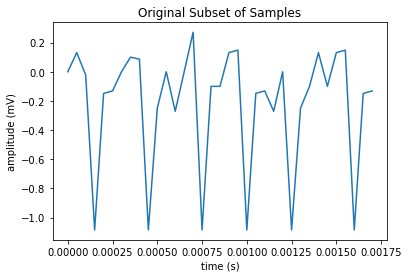

In [1109]:
# Plot original subset of samples
plt.title("Original Subset of Samples")
plt.plot(t[np.arange(0, len(x_subset))], x_subset)
plt.xlabel('time (s)')
plt.ylabel('amplitude (mV)')
plt.show()

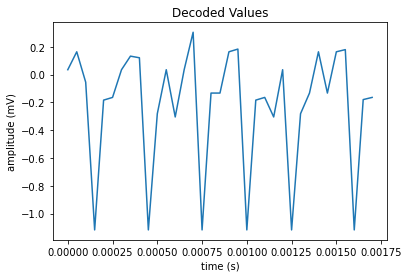

In [1110]:
# Plot decoded values (from the Rice-Golomb encoded values)
plt.title("Decoded Values")
plt.plot(t[np.arange(0, len(x_subset))], decoded_values)
plt.xlabel('time (s)')
plt.ylabel('amplitude (mV)')
plt.show()

You can see here that the decoded values and the original subset of samples (ground truth) are very similar in plot shape, as their values scale similarly. That means our encoding/decoding works properly. 

## <font color='red'>Lossy Compression</font>

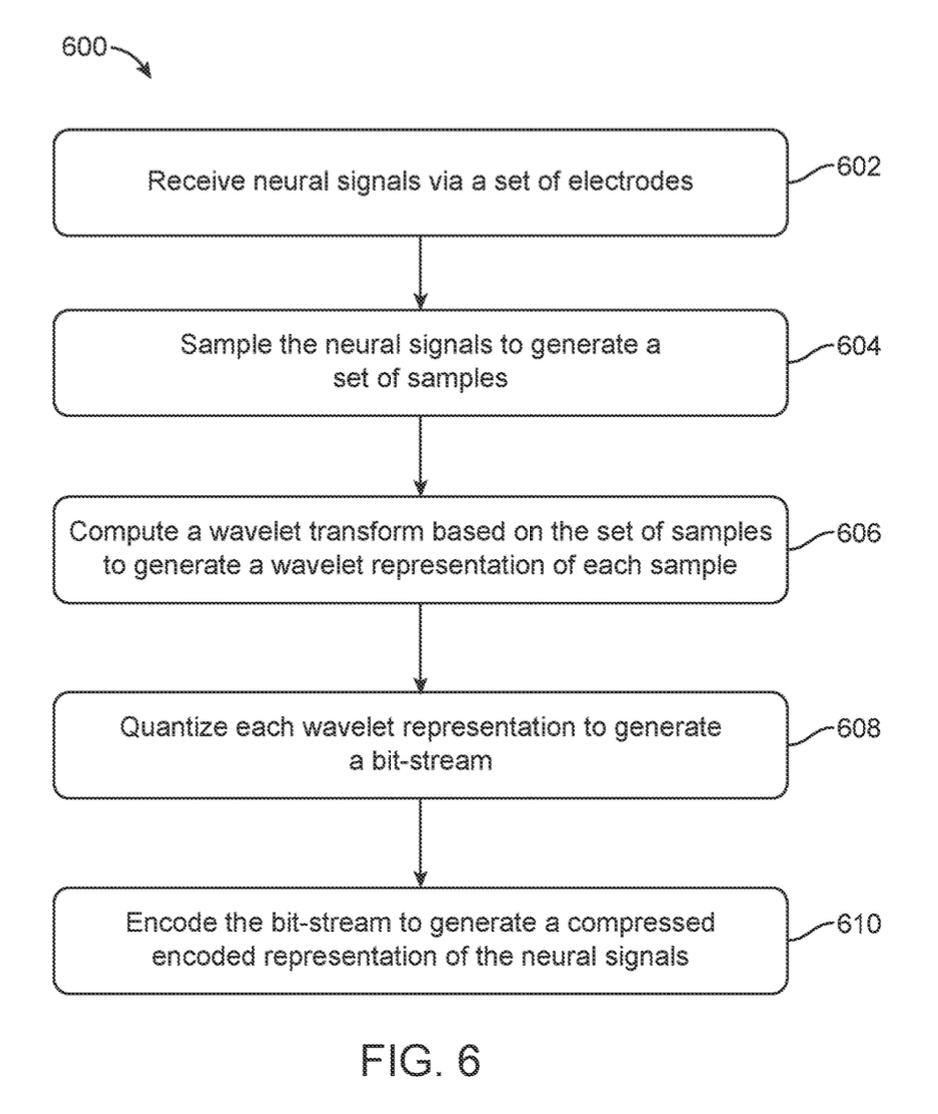

### 1. Receive Signal

Receive neural signals from electrodes. 

### 2. Generate Set of Samples (that correspond to spikes)

Detect spikes in the signal. 

Refer to the [notebook](https://github.com/michaela10c/neural_spike_detection/) for US patent 2021/0012909 A1, "Real-Time Neural Spike Detection". 

Let's **reuse the results from the first two steps** from the last part (Lossless Compression Algorithm), since they are **identical**. 

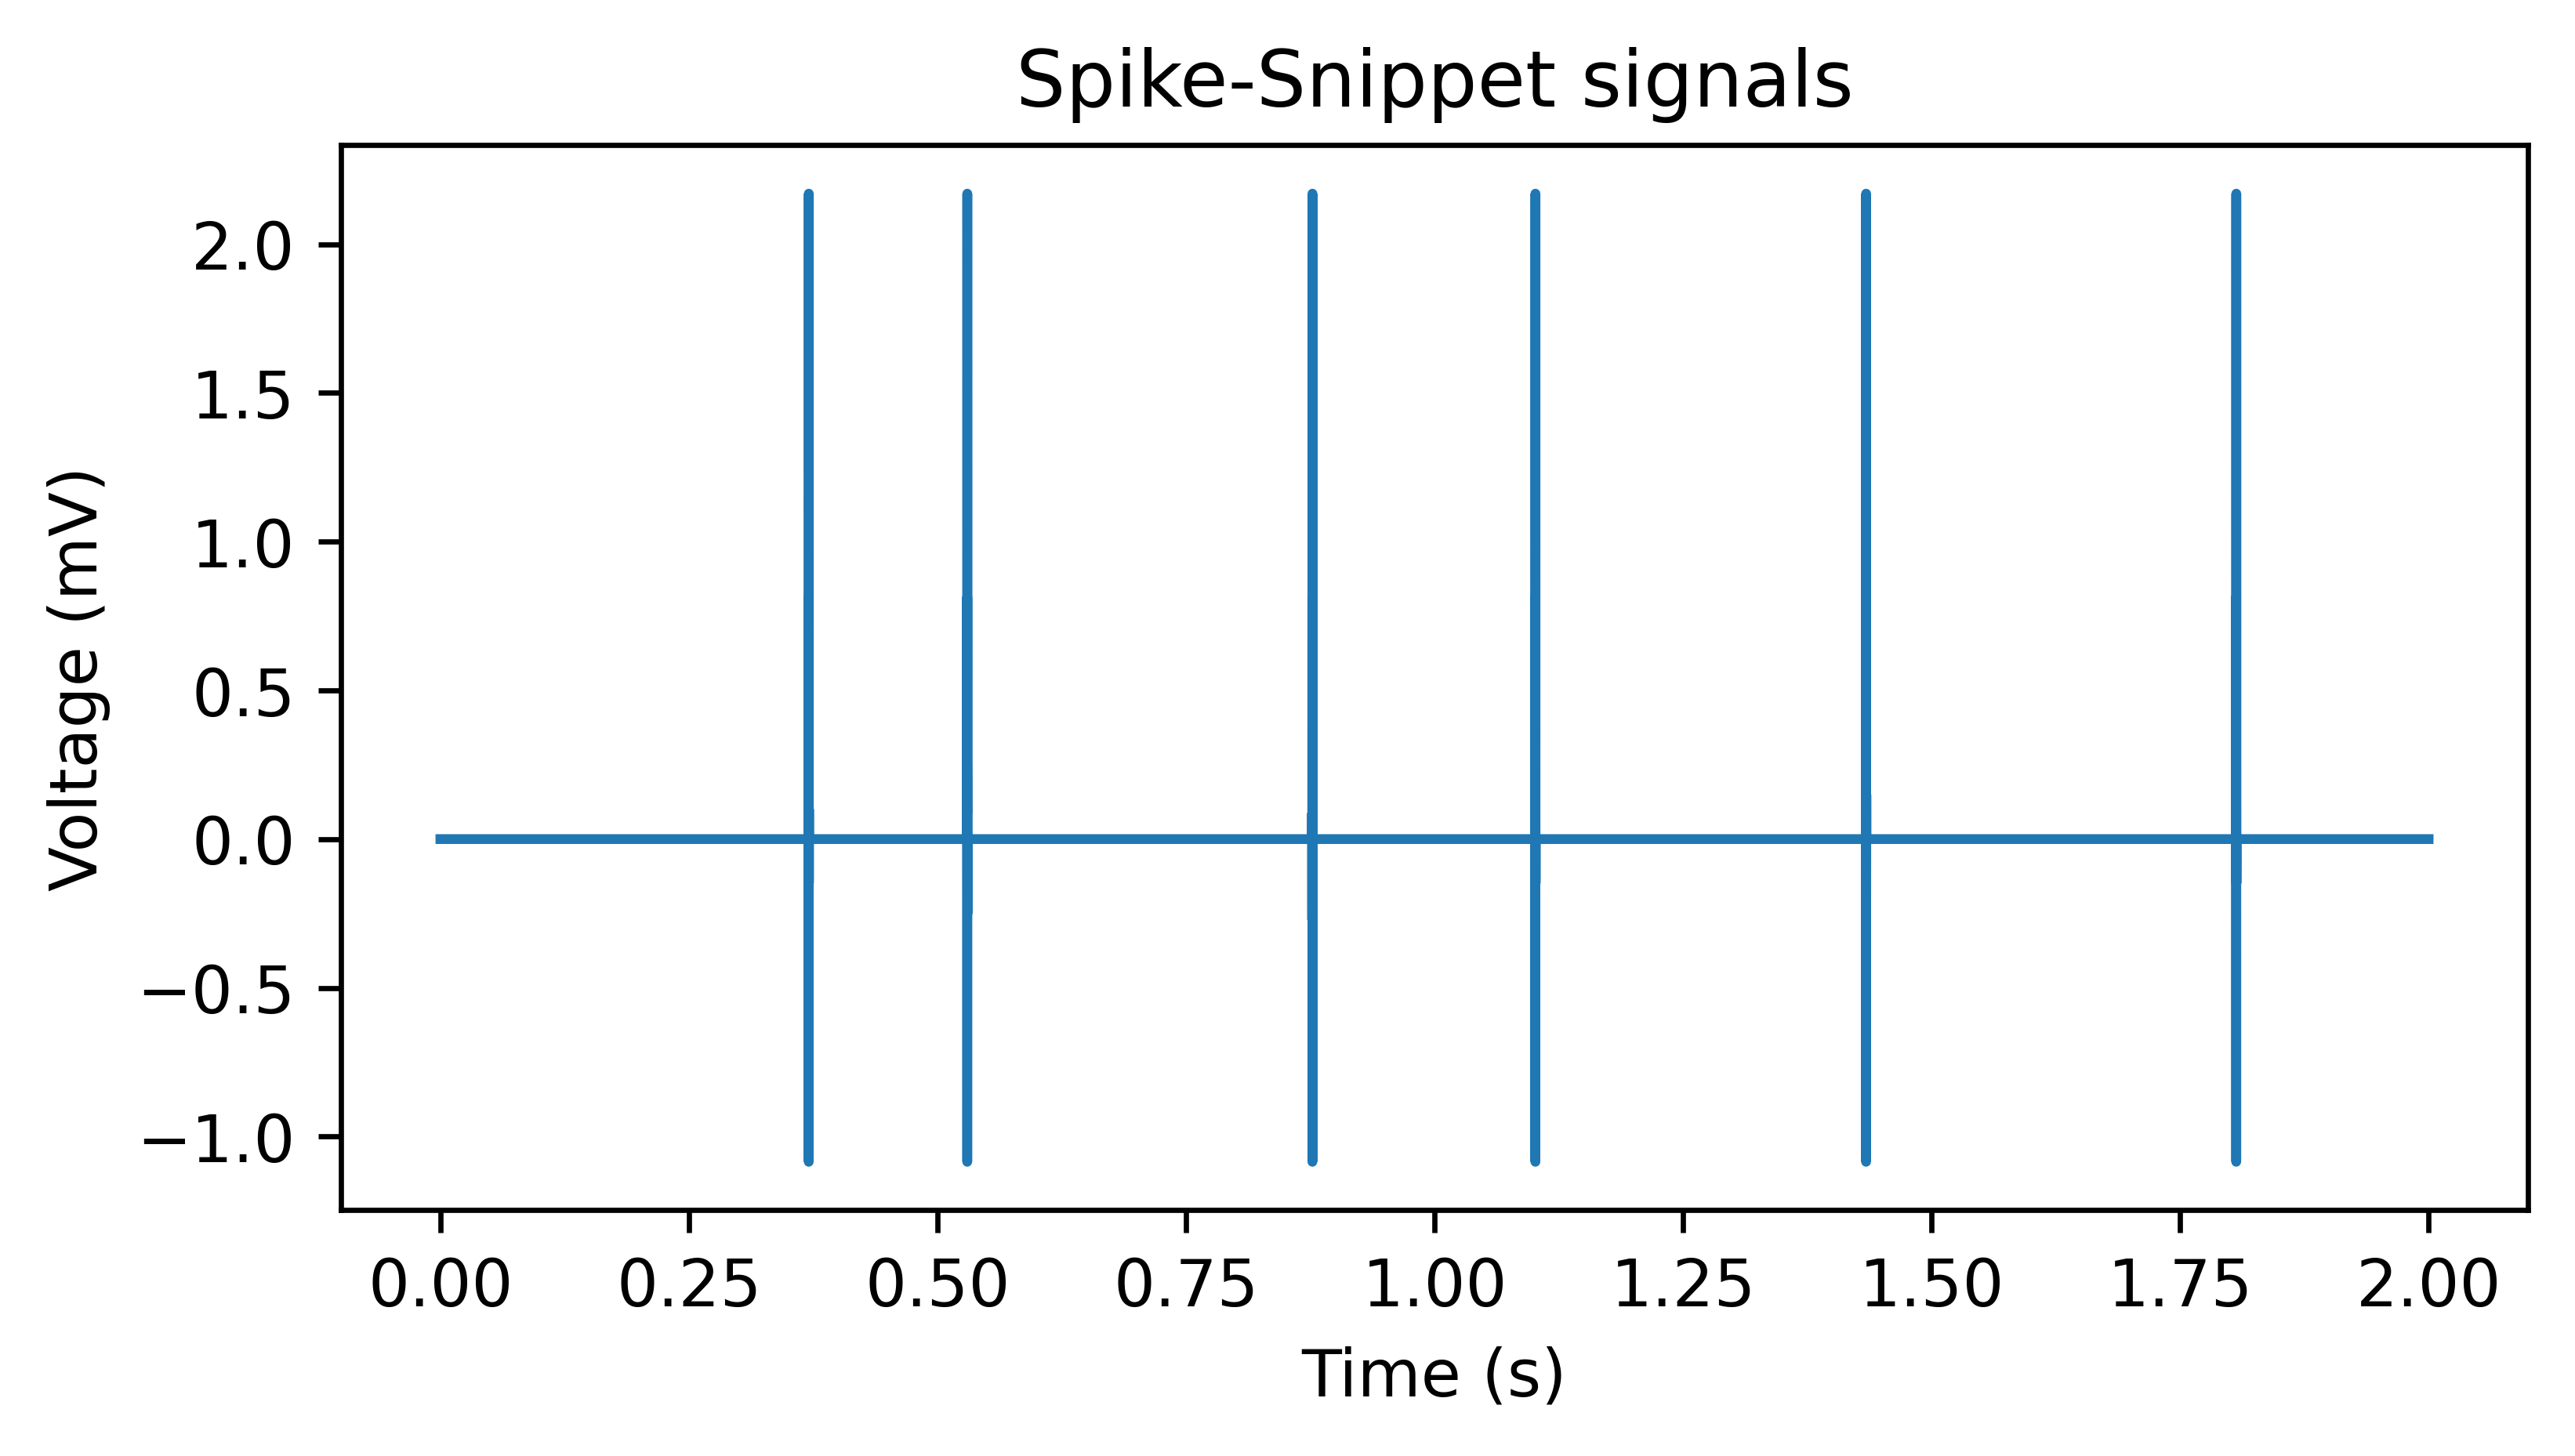

In [1111]:
# Plot the spike-snippet signals
fig, ax = plt.subplots(1, 1, figsize=(6, 3),dpi = 600)

plt.title("Spike-Snippet signals")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (s)")

plt.plot(t, x_snippets)
plt.show()

Show the spikes dataframe:

In [1112]:
# Show the dataframe of spikes
df

,lp,mp,rp,lv,mv,rv,ldist,rdist,ratio,asym,cost,thres
0,0.3501,0.35695,0.37055,0.253896,-0.260486,0.477330,0.00685,0.01360,1.832460,0.531910,0.010053,1.240961e-03
1,0.4801,0.50195,0.53000,0.253910,-0.260470,0.453036,0.02185,0.02805,1.739303,0.560463,0.006118,7.019947e-04
2,0.8241,0.84695,0.87710,0.253913,-0.260461,0.546791,0.02285,0.03015,2.099323,0.464370,0.000765,-3.298368e-07
3,1.0491,1.04995,1.10150,0.253923,-0.260499,0.471340,0.00085,0.05155,1.809375,0.538726,0.004156,4.456981e-04
4,1.3931,1.41795,1.43415,0.253896,-0.260478,0.518901,0.02485,0.01620,1.992108,0.489297,0.002261,1.967426e-04
5,1.7281,1.73795,1.80650,0.253916,-0.260456,0.471341,0.00985,0.06855,1.809679,0.538709,0.003040,2.977712e-04


We want to pick the **subset** of signals that correspond to **spikes**.

In [1113]:
# Get all non-zero signals of the spike snippets
nonzero_indices = np.where(x_snippets != 0)[0]
x_snippets_nonzero = x_snippets[nonzero_indices]

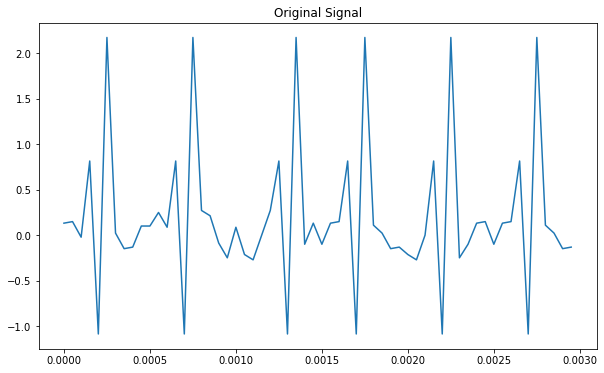

In [1114]:
# Plot the non-zero signals of the spike snippets
plt.figure(figsize=(10, 6))
plt.plot(t[np.arange(0, len(x_snippets_nonzero))], x_snippets_nonzero, label='Original Signal')
plt.title('Original Signal')
plt.show()

### 3. Determine Wavelet Transform (Decompose into Wavelets)

Determine the wavelet representations for each sample by performing a **wavelet transform** w.r.t. the set of samples, such as a **discrete wavelet transform (DWT)**, which decomposes the signal into a number of sets of time series of coefficients describing the time evolution in corresponding frequency band.  

Essentially, what we are doing here is **decomposing the original spike-snippets signal** (where each spike looks like an individual **wavelet**) into different components. 

Using **[Biorthogonal 2.2 wavelet (Bior 2.2)](https://wavelets.pybytes.com/wavelet/bior2.2/)**, we can see that there is **1 set of approximation coefficients** and **3 sets of detail coefficients**. 

In [1115]:
def perform_wavelet_decomposition(signal, wavelet='bior2.2', level=3):
    """Perform wavelet decomposition and retain only the approximation coefficients."""
    coefficients = pywt.wavedec(signal, wavelet, level=level)
    
    return coefficients[0], coefficients[1:]

In [1116]:
# Perform wavelet decomposition and retain both approximation and detail coefficients
approximation_coeffs, detail_coeffs = perform_wavelet_decomposition(x_snippets_nonzero)

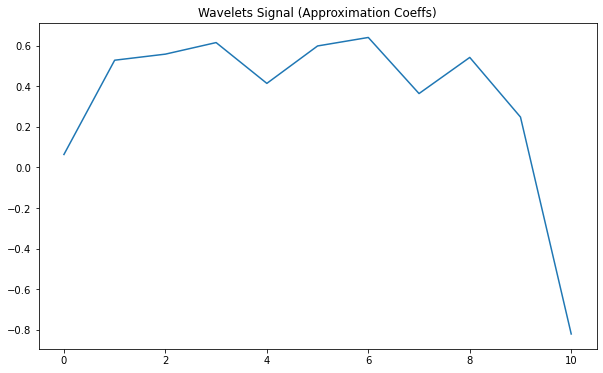

In [1117]:
# Plot approximation coeffs
plt.figure(figsize=(10, 6))
plt.plot(approximation_coeffs)
plt.title('Wavelets Signal (Approximation Coeffs)')
plt.show()

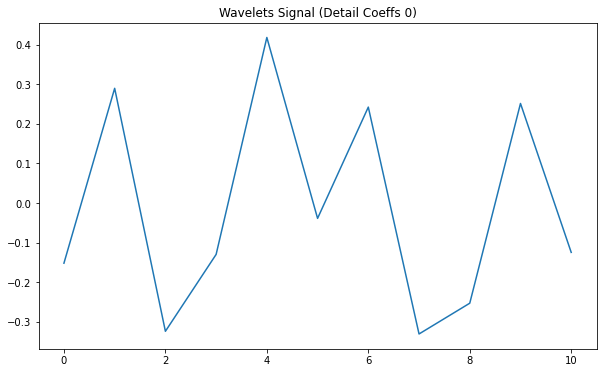

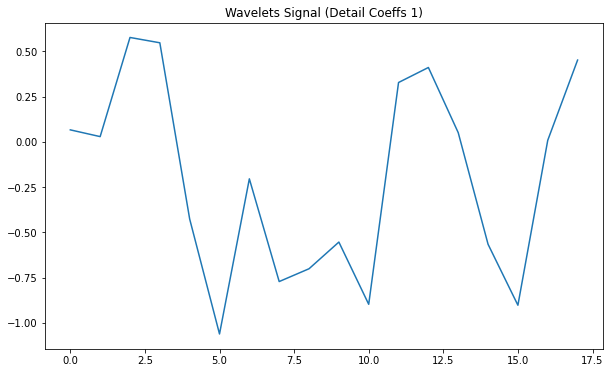

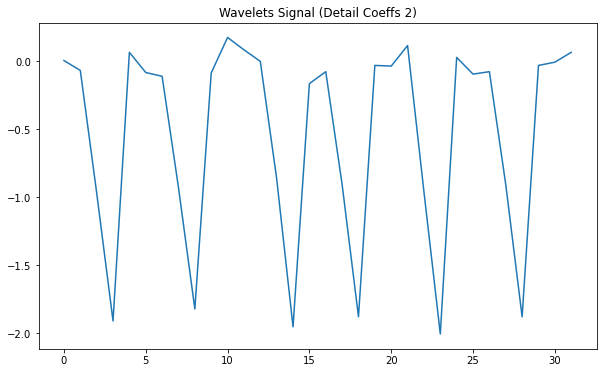

In [1118]:
# Plot detail coeffs
i = 0
for coeffs in detail_coeffs:
    plt.figure(figsize=(10, 6))
    plt.plot(detail_coeffs[i])
    plt.title('Wavelets Signal (Detail Coeffs ' + str(i) + ')')
    plt.show()
    i += 1

### 4. Quantize Wavelets to Bitstream

Quantizing the wavelets **restricts each wavelet representation** into **discrete (unary/binary) values**, using techniques such as **[probability mass function (PMF) quantization](https://ocw.mit.edu/courses/6-450-principles-of-digital-communications-i-fall-2006/926689aaa62a0315473fa9b982de1b07_book_3.pdf)**. This **restricts** each wavelet representation into **discrete values** (unary and/or binary values). 

We effectively **reduce the amount of bits or computational resources per detail**, with the **most important information** stored in **lower frequencies** (with higher frequency close to little or no information). 

In [1119]:
def estimate_pmf(data, num_bins=6):
    """Estimate the probability mass function (PMF) based on the data."""
    hist, bins = np.histogram(data, bins=num_bins, density=True)
    pmf = hist / np.sum(hist)
    return pmf, bins

def define_quantization_levels(pmf, bins):
    """Define quantization levels based on the PMF."""
    num_levels = len(pmf)
    
    # Adaptive quantization based on the PMF
    quantization_levels = np.zeros(num_levels)
    cumulative_pmf = np.cumsum(pmf)
    for i in range(num_levels):
        idx = np.argmin(np.abs(cumulative_pmf - (i + 0.5) / num_levels))
        quantization_levels[i] = bins[idx + 1]
    return quantization_levels

def quantize_coeffs(approximation_coeffs, quantization_levels):
    """Quantize the approximation coefficients based on the specified quantization levels."""
    quantized_coeffs = np.zeros_like(approximation_coeffs)
    for i, coeff in enumerate(approximation_coeffs):
        quantized_coeffs[i] = np.digitize(coeff, quantization_levels)
    return quantized_coeffs

In [1120]:
# Estimate PMF based on the approximation coefficients
pmf, bins = estimate_pmf(approximation_coeffs)

# Define quantization levels based on the PMF
quantization_levels = define_quantization_levels(pmf, bins)

# Apply quantization to the approximation coefficients
quantized_approx_coeffs = quantize_coeffs(approximation_coeffs, quantization_levels)

### 5. Encode Bitstream

Append the **details** from the wavelet representation into the bit stream.

Use **[range Asymmetric Numerical Systems (rANS)](https://kedartatwawadi.github.io/post--ANS/)** to encode bit stream. 

An application of rANS, such as **fast rANS (frANS)**, may be used to **relax some constraints (e.g., PMF quantization)**, causing a **marginal loss of data ("lossy")**, while keeping the **accuracy loss negligible**.  

Note that since rANS is an **entropy-coding method**, it relies on **accurately classifying spikes in each bin based on spike categories**, as it **increases compression ratio** from 8:1 to 23:1. 

In [1121]:
def rANS_encode_relaxed_pmf(quantized_coeffs, pmf):
    """Encode quantized coefficients using fast rANS encoding with relaxed PMF constraint."""
    num_levels = len(pmf)
    
    # Calculate relaxed probabilities based on the provided PMF
    probabilities = pmf / np.sum(pmf)
    
    # Generate rANS encoded data
    encoded_data = bytearray()
    for coeff in quantized_coeffs:
        for level in coeff:
            # Encode quantized coefficient based on probabilities
            symbol = np.random.choice(np.arange(num_levels), p=probabilities)
            encoded_data.extend(int(symbol).to_bytes(1, byteorder='big'))  # Convert symbol to bytes and append
            
    # Compress using zlib
    compressed_data = zlib.compress(encoded_data)
    return compressed_data

In [1122]:
# Encode quantized detail coefficients using fast rANS encoding
compressed_data = rANS_encode_relaxed_pmf(quantized_detail_coeffs, pmf)

# Calculate compression ratio
original_size = x_snippets_nonzero.nbytes
compressed_size = len(compressed_data)
compression_ratio = original_size / compressed_size

print("Compression ratio:", compression_ratio)

Compression ratio: 13.333333333333334


### Encoded Bitstream:

In [1123]:
def bytes_to_bitstream(bytes_data):
    """Convert bytes data to a binary string."""
    return ''.join(format(byte, '08b') for byte in bytes_data)

# Convert compressed data to bitstream
bitstream = bytes_to_bitstream(compressed_data)

# Sample usage
print("Compressed bitstream:", bitstream)

Compressed bitstream: 011110001001110001100011011001010000010100000010000101100001000001100110011001100110011001100001000000000011000101000001000111000101011001100110010101100010100000000000111100101001100101000001001111000001011010101000001100100000100000000001101001010000000000100001010111100000000100011000


### Additional: Decode Bitstream

Reconstruct the original signal.

In [1124]:
def bitstream_to_bytes(bitstream):
    """Convert a binary string (bitstream) to bytes."""
    bytes_data = bytearray()
    for i in range(0, len(bitstream), 8):
        byte = bitstream[i:i+8]
        bytes_data.append(int(byte, 2))
    return bytes(bytes_data)

def rANS_decode_relaxed_pmf(compressed_data, pmf):
    """Decode compressed data using fast rANS decoding with relaxed PMF constraint."""
    num_levels = len(pmf)
    
    # Calculate relaxed probabilities based on the provided PMF
    probabilities = pmf / np.sum(pmf)
    
    # Decompress using zlib
    decompressed_data = zlib.decompress(compressed_data)
    
    # Initialize decoded coefficients
    decoded_coeffs = []
    
    # Decode rANS encoded data
    byte_index = 0
    while byte_index < len(decompressed_data):
        byte = decompressed_data[byte_index]
        symbol = byte & 0xFF
        decoded_coeffs.append(symbol)
        byte_index += 1
    
    # Convert to numpy array
    decoded_coeffs = np.array(decoded_coeffs)
    
    return decoded_coeffs

def dequantize_coeffs(quantized_coeffs, quantization_levels):
    """Dequantize the quantized coefficients based on the specified quantization levels."""
    if np.ndim(quantized_coeffs) == 0:  # Check if quantized_coeffs is a single coefficient
        return quantization_levels[quantized_coeffs]
    else:
        dequantized_coeffs = np.zeros_like(quantized_coeffs, dtype=float)
        for i, coeff in enumerate(quantized_coeffs):
            dequantized_coeffs[i] = quantization_levels[coeff]
        return dequantized_coeffs

def perform_inverse_wavelet_transform(approximation_coeffs, dequantized_detail_coeffs, original_detail_coeffs, wavelet='bior2.2'):
    """Perform inverse wavelet transform to reconstruct the original signal."""
    # Get the number of levels of the originally computed detail coefficients + individual lengths of each level
    coeff_lengths = np.array([len(coeffs) for coeffs in original_detail_coeffs])    
    dequantized_detail_coeffs_array = []
    
    i = 0 
    for coeff_len in coeff_lengths:
        arr = []
        for j in range(coeff_len):
            if i >= len(dequantized_detail_coeffs):
                continue
                
            arr.append(dequantized_detail_coeffs[i])
            i += 1
        dequantized_detail_coeffs_array.append(np.array(arr))
    
    assert(len(dequantized_detail_coeffs_array) == len(original_detail_coeffs))
    assert(len(dequantized_detail_coeffs_array[i]) == len(original_detail_coeffs[i]) for i in range(len(original_detail_coeffs)))
    
    reconstructed_signal = pywt.waverec([approximation_coeffs] + dequantized_detail_coeffs_array, wavelet)
    return reconstructed_signal

# Decode compressed data using fast rANS decoding with relaxed PMF
decoded_detail_coeffs = rANS_decode_relaxed_pmf(compressed_data, pmf)

# Dequantize the detail coefficients
dequantized_detail_coeffs = [dequantize_coeffs(coeff, quantization_levels) for coeff in decoded_detail_coeffs]

# Reconstruct the signal using inverse wavelet transform
reconstructed_signal = perform_inverse_wavelet_transform(quantized_approx_coeffs, dequantized_detail_coeffs, detail_coeffs)

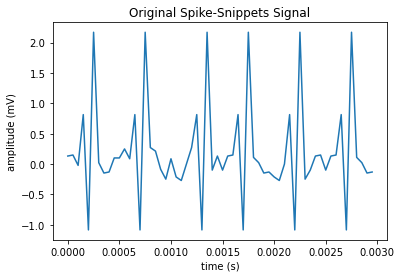

In [1125]:
# Plot original subset of spike-snippets
plt.title("Original Spike-Snippets Signal")
plt.plot(t[np.arange(0, len(x_snippets_nonzero))], x_snippets_nonzero)
plt.xlabel('time (s)')
plt.ylabel('amplitude (mV)')
plt.show()

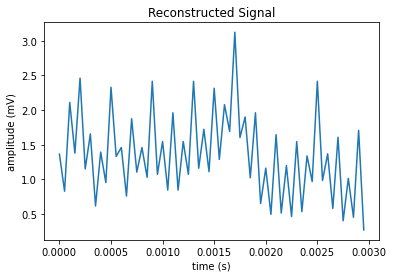

In [1126]:
# Plot reconstructed signal
plt.title("Reconstructed Signal")
plt.plot(t[np.arange(0, len(reconstructed_signal))], reconstructed_signal)
plt.xlabel('time (s)')
plt.ylabel('amplitude (mV)')
plt.show()

Since we are in "lossy" compression mode, we expect the original and reconstructed signals to be different, because of the loss of information due to relaxing the PMF constraints during fast rANS encoding.  

## <font color='green'> Sparse Compression: Binned-Spikes </font> 

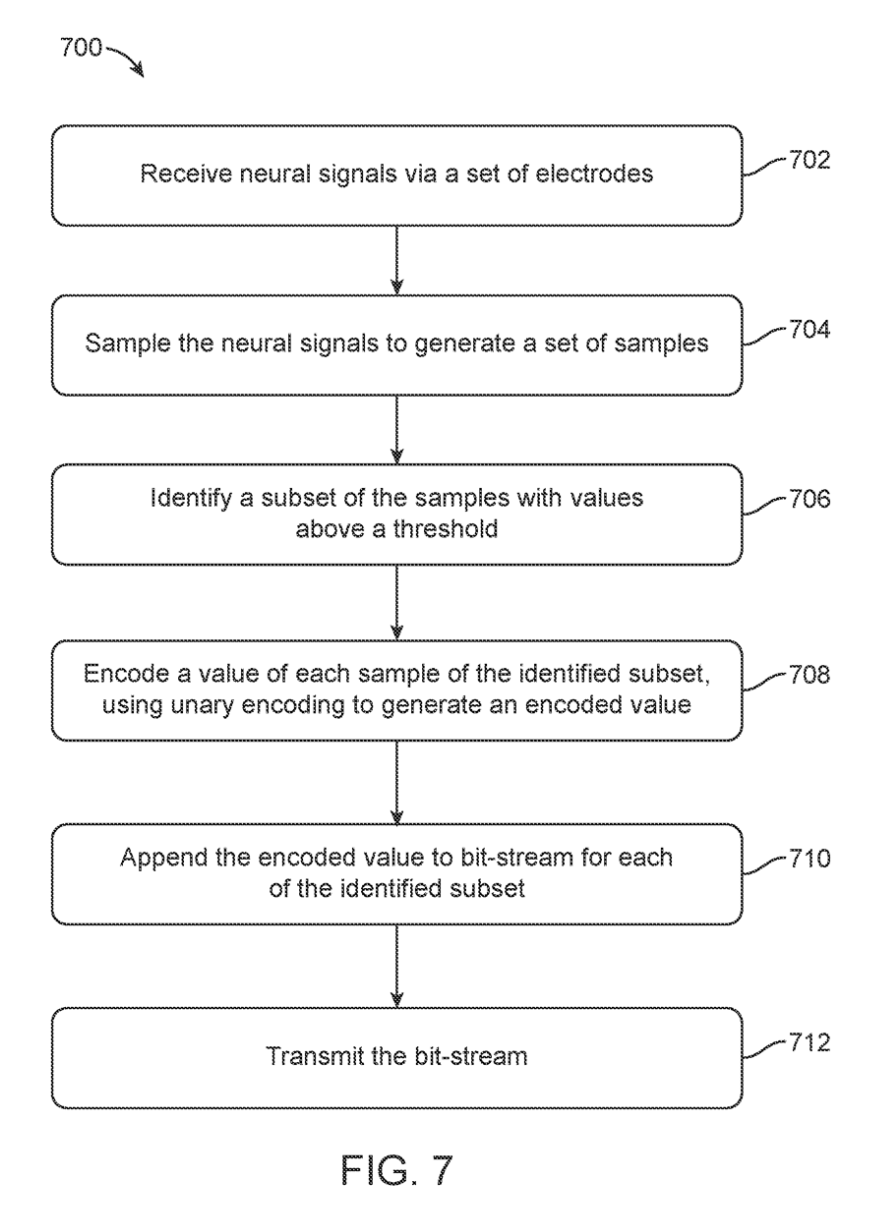

### 1. Receive Signal

Receive neural signals from electrodes. 

### 2. Generate Set of Samples (that correspond to spikes)

Detect spikes in the signal. 

Refer to the [notebook](https://github.com/michaela10c/neural_spike_detection/) for US patent 2021/0012909 A1, "Real-Time Neural Spike Detection". 

Let's **reuse the results from the first two steps** from the last part (Lossless Compression Algorithm), since they are **identical**. 

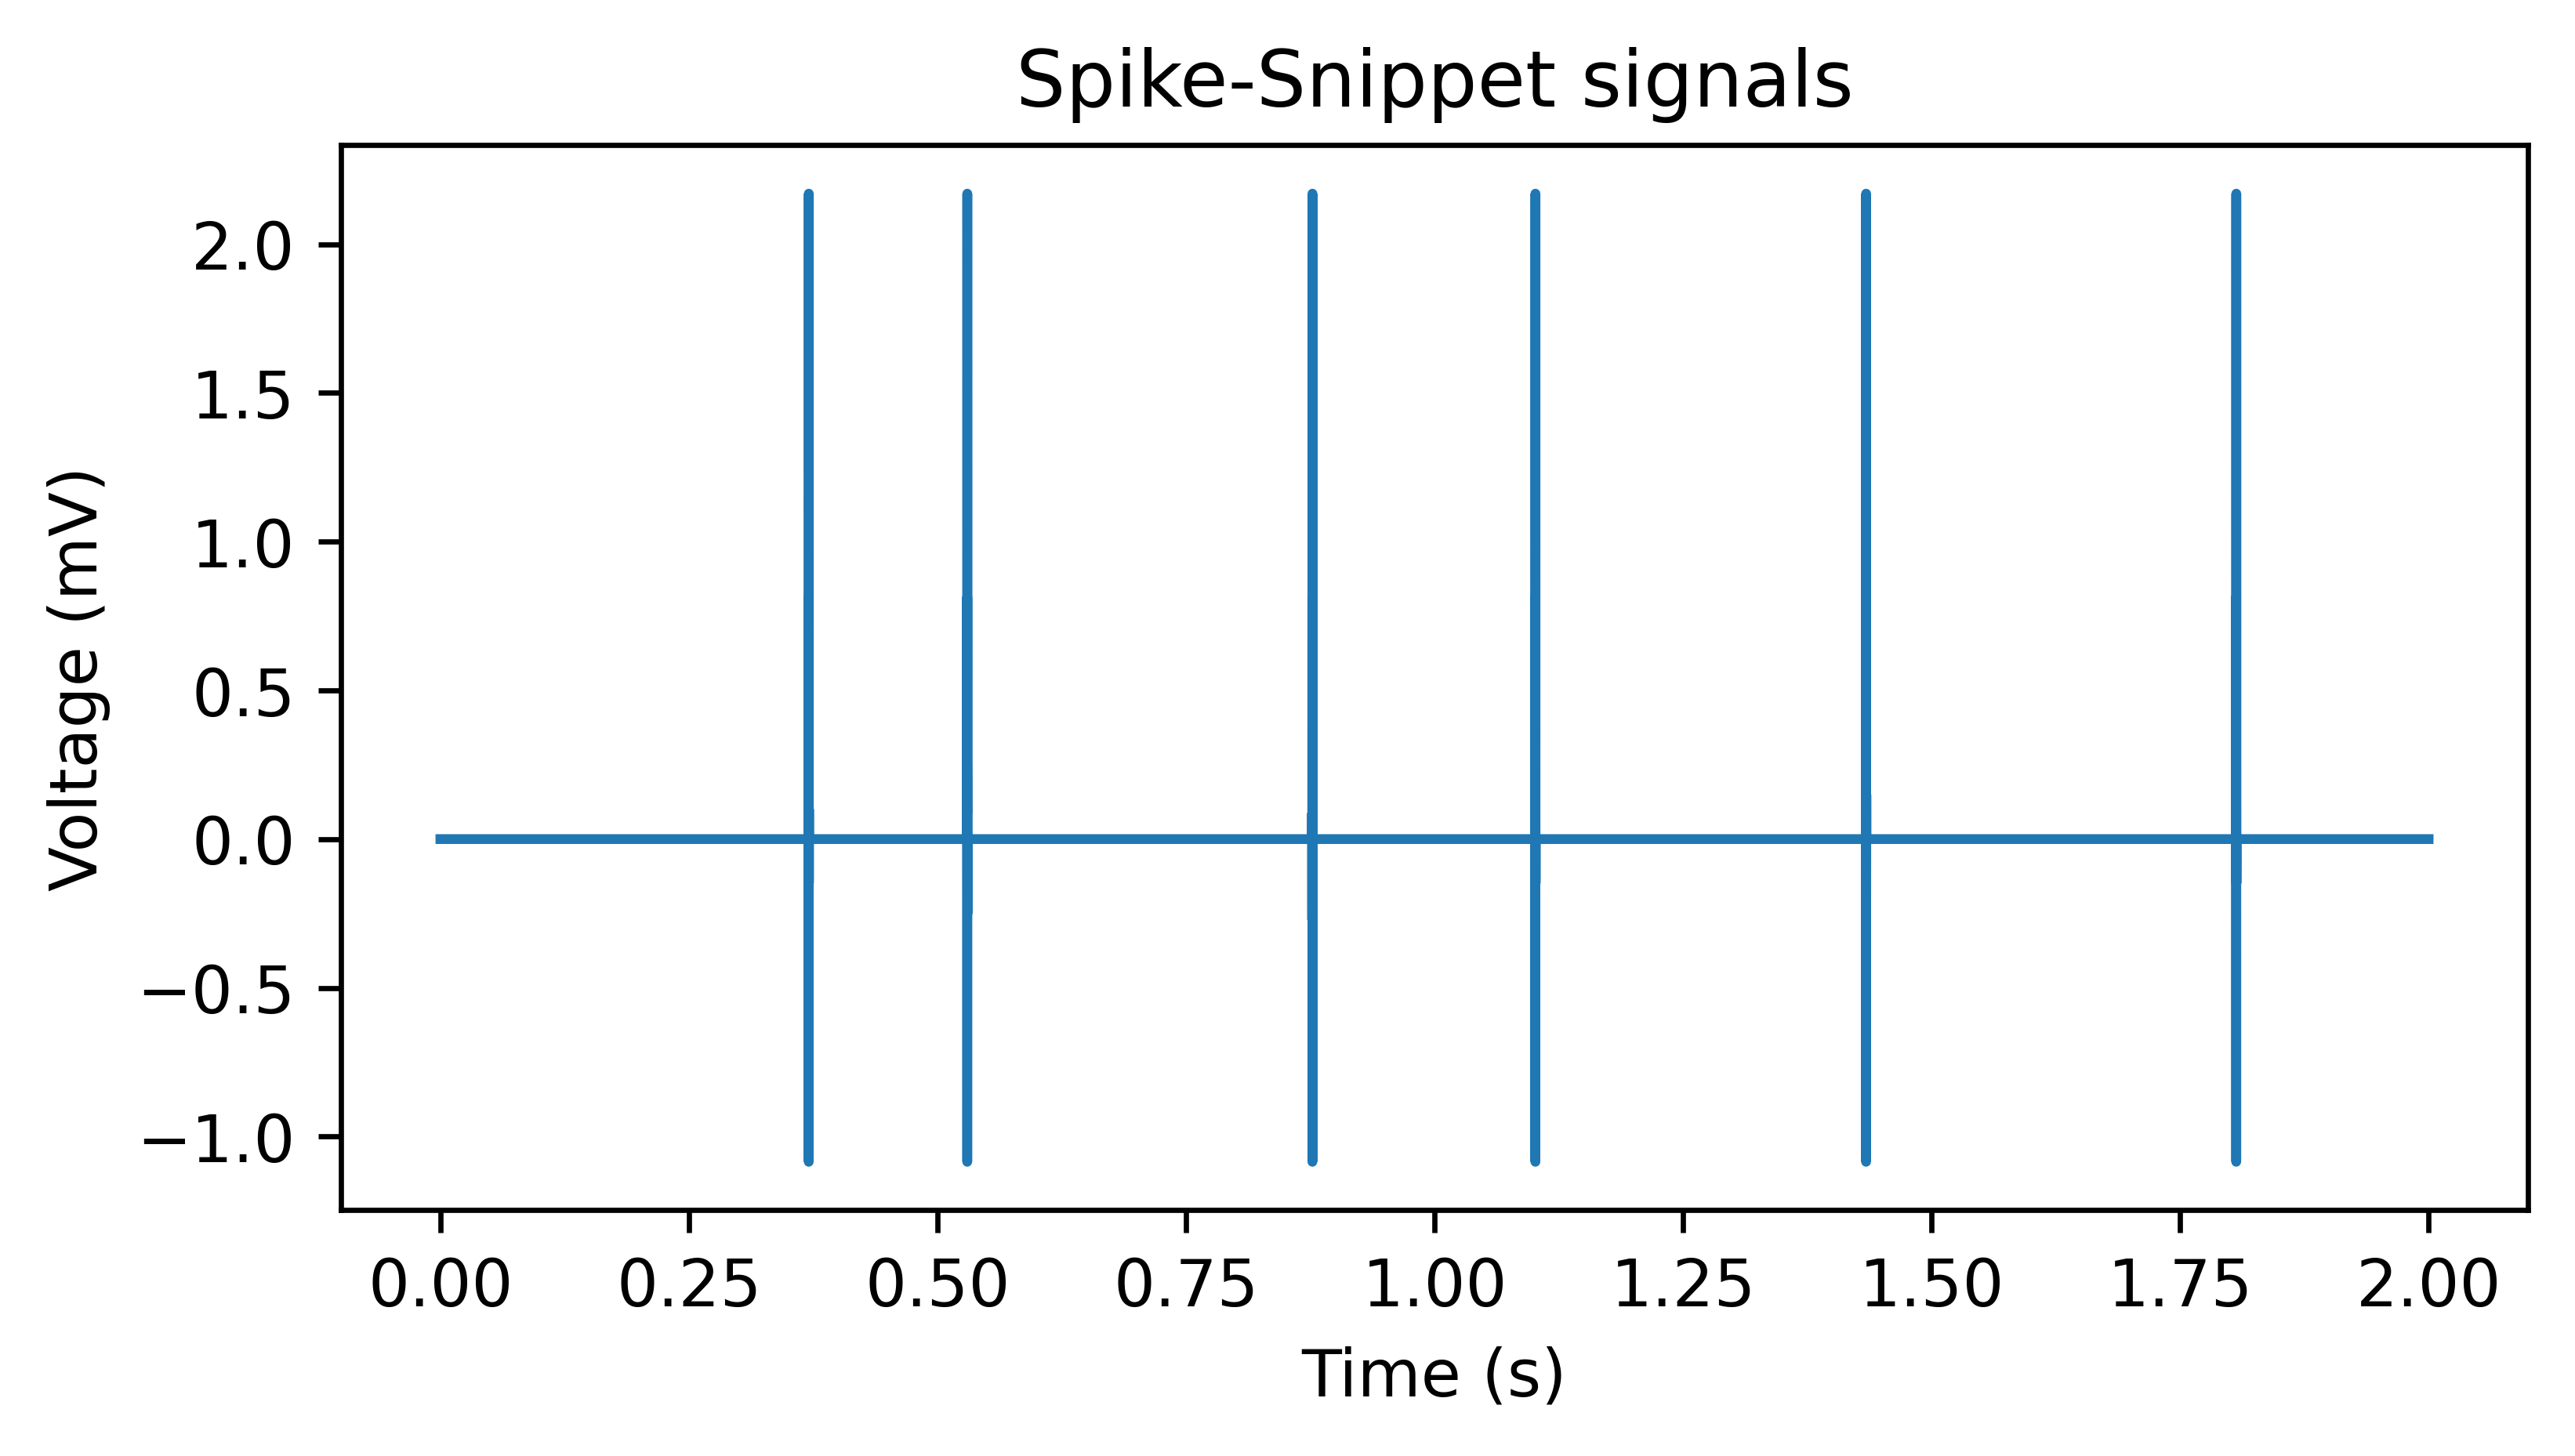

In [1127]:
# Plot the spike-snippet signals
fig, ax = plt.subplots(1, 1, figsize=(6, 3),dpi = 600)

plt.title("Spike-Snippet signals")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (s)")

plt.plot(t, x_snippets)
plt.show()

### 3. Identify non-zero subset of samples 

Filter out all values that equal to zero to leverage the sparse nature of neural signals. **DO NOT transmit if all signals are zero.**

In [1128]:
nonzero_indices = np.where(np.abs(x_snippets) > 0)[0]
x_nonzero = np.abs(x_snippets[nonzero_indices])
t_nonzero = t[nonzero_indices]

In [1129]:
# Transmit the signal only when there are 1 or more non-zero values
transmit = len(x_nonzero) != 0
transmit

True

### 4. Encode non-zero values via unary uncoding

Use the same procedure as described in "Lossless Compression", except that we are ignoring the remainder (binary encoding). 

In [1130]:
def unary_encoding(value, m):
    abs_value = abs(value)
    quotient = abs_value // m # q = int(x / m)
    unary_code = '1' * quotient + '0' 
    return unary_code

In [1131]:
values_q88 = (x_nonzero * (2**frac_bits)).astype(int)
unary = np.vectorize(unary_encoding)
encoded_values = unary(values_q88, m)

### 5. Append encoded values to bitstream

If all values are zero or close to zero -> append "0" to bit stream 

Otherwise, if 1 or more values are non-zero -> append "1" + each encoded value to bit stream

In [1132]:
if transmit:
    # append "1" + each encoded value to bit stream
    bitstream = '1'
    
    for value in encoded_values:
        bitstream += value
else:
    # append "0" to bit stream
    bitstream = '0' 

### 6. Transmit Bitstream 

Transmit bitstream to external device.

**Note: Do NOT transmit bitstream if all samples are zero**

In [1133]:
bitstream

'111101111001111111111111111111111101111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111100111101110110110111111101101111111111111111111111101111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111101111111011111101101111111011011111101111111001111111011111111111111111111111011111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111011011101101110111101111111111111111111111101111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111101110011110111011111101111111001111111111111111111111101111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111101111111011011101111011011101111011111111111111111111111011111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111011100111101110'

### Additional: Decode bitstream

External device decodes bitstream for further analysis

Reverse all or some steps from above process - **reconstruct samples**

In [1134]:
def unary_decoding(encoded_value, m):
    quotient = encoded_value.index('0')
    abs_value = quotient * m
    return abs_value

In [1135]:
decoded_values = []

if transmit:
    index = 1 # ignore the 'transmit' bit ('1')
    while index < len(bitstream):
        substr_end = index + bitstream[index:].index('0') + 1
        decoded_value_q88 = unary_decoding(bitstream[index : substr_end], m)
        decoded_value = decoded_value_q88 / (2**frac_bits)
        decoded_values.append(decoded_value)
        index = substr_end

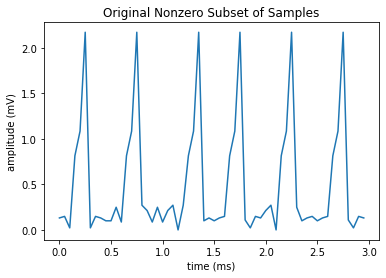

In [1136]:
# Plot original nonzero subset of samples
plt.title("Original Nonzero Subset of Samples")
plt.plot(1000 * t[np.arange(0, len(x_nonzero))], x_nonzero)
plt.xlabel('time (ms)')
plt.ylabel('amplitude (mV)')
plt.show()

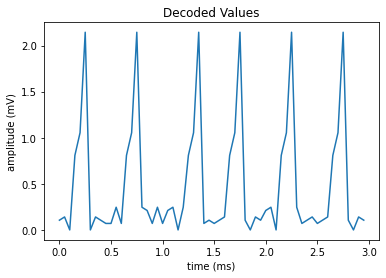

In [1137]:
# Plot decoded values 
plt.title("Decoded Values")
plt.plot(1000 * t[np.arange(0, len(decoded_values))], decoded_values)
plt.xlabel('time (ms)')
plt.ylabel('amplitude (mV)')
plt.show()

You can see here that the decoded values and the original subset of samples (ground truth) are very similar in plot shape, as their values scale similarly. That means our encoding/decoding works properly. 

## <font color='green'>Sparse Compression: Spike-Band</font>

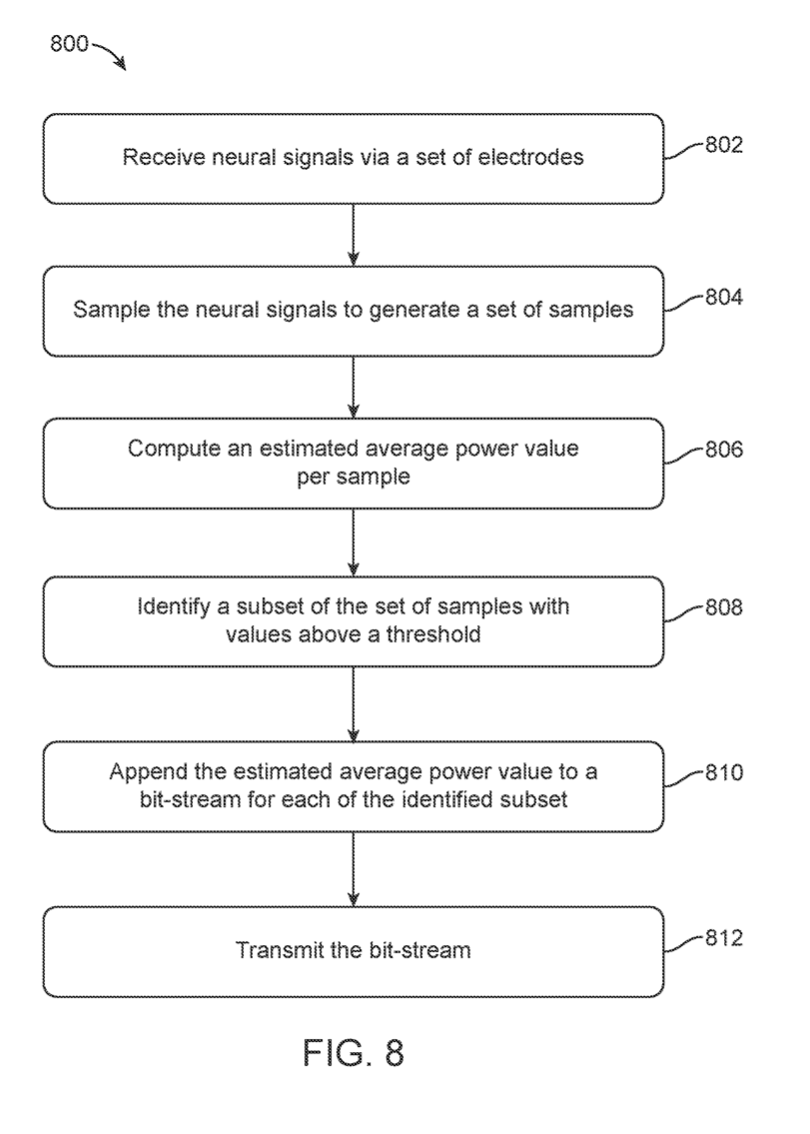

### 1. Receive Signal + Detect Spikes

Receive neural signals from electrodes, and only keep the signals corresponding to spikes. 

Then apply a filter to this signal. 

Refer to the [notebook](https://github.com/michaela10c/neural_spike_detection/) for US patent 2021/0012909 A1, "Real-Time Neural Spike Detection". 

Let's **reuse the results from the first two steps** from the last part (Lossless Compression Algorithm), since they are **identical**. 

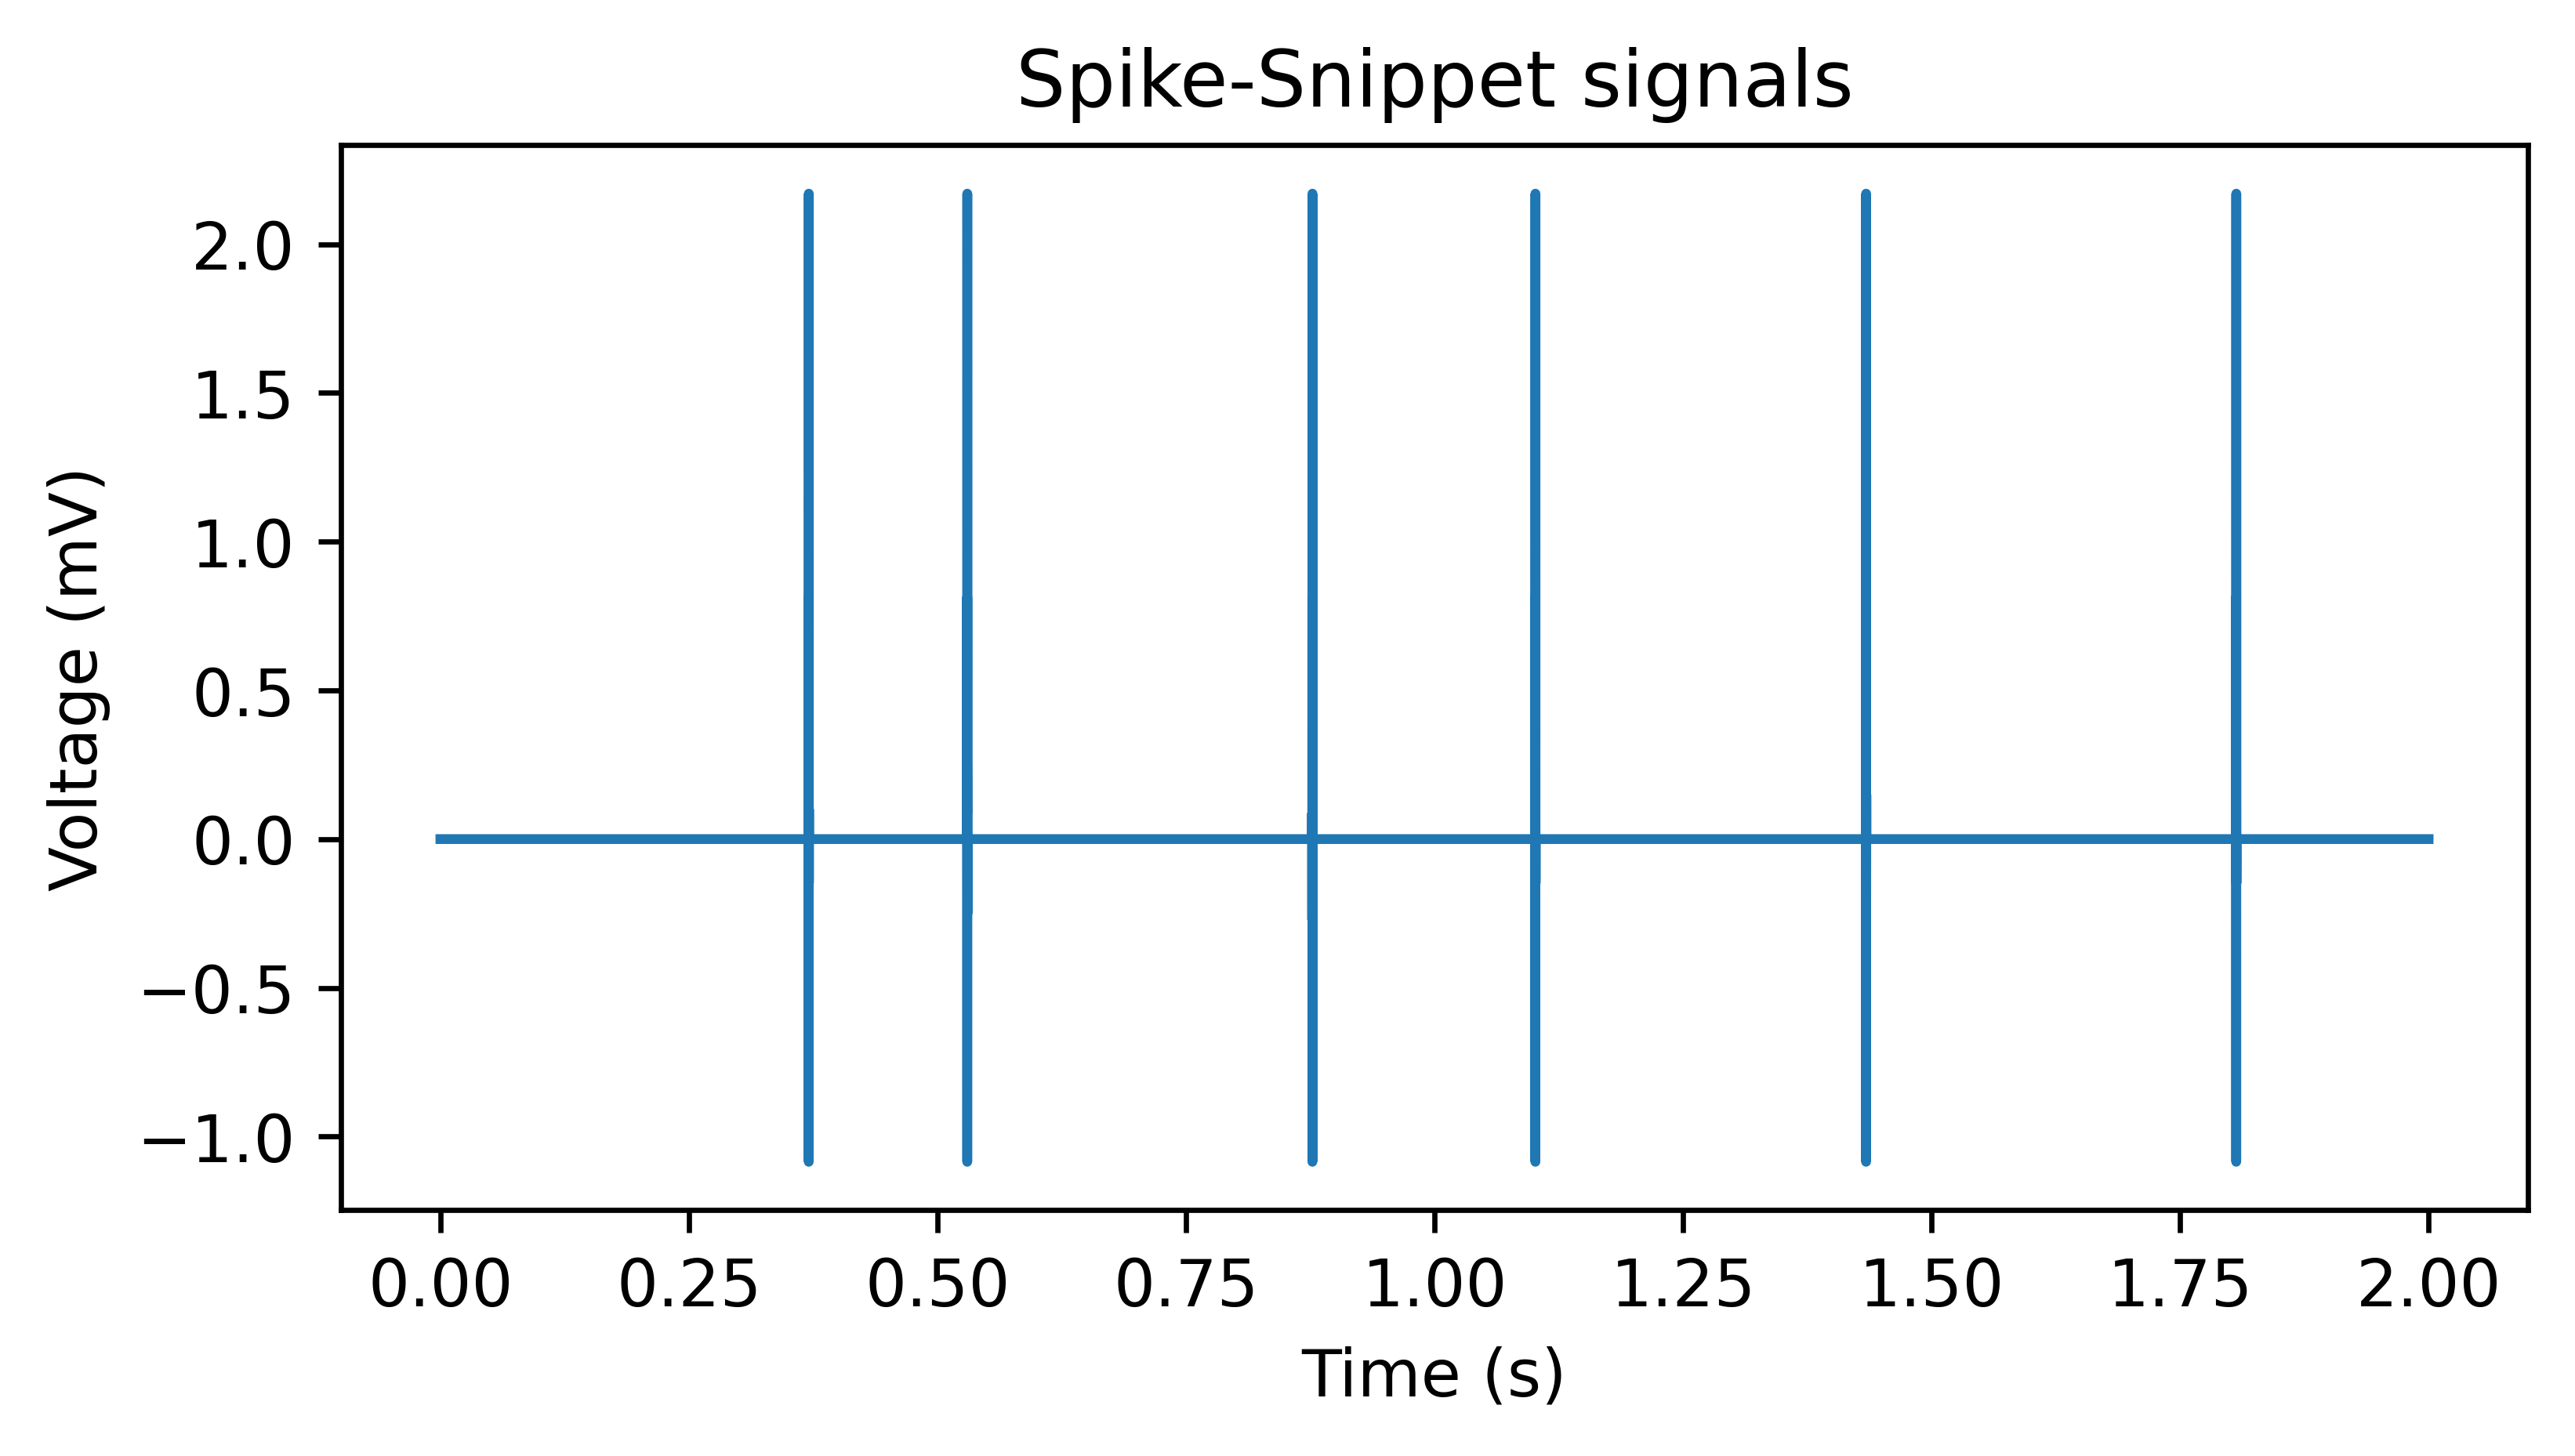

In [1138]:
# Plot the spike-snippet signals
fig, ax = plt.subplots(1, 1, figsize=(6, 3),dpi = 600)

plt.title("Spike-Snippet signals")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (s)")

plt.plot(t, x_snippets)
plt.show()

In [1139]:
# Apply a filter to the spike-snippets signal
filtered_signal = spike_detector.filter_signal(x_snippets)

### 2. Generate Set of Samples

Compute an absolute value of each sampled channel. Each sample represents a channel. 

In [1140]:
filtered_signal = np.abs(filtered_signal)

### 3. Calculate average power (i.e., average amplitude)

Compute average power for each fixed time window.

In [1141]:
def average_val(signal, i1, i2):
    return np.mean(signal[i1 : i2])

In [1142]:
def average_power(signal, blackout_period=0.01):
    index = 0
    duration = time_to_index(blackout_period)
    mean = []
    
    while index < len(signal) - duration:
        avg = average_val(signal, index, index + duration)
        mean.append(avg)
        index += 1
        
    return np.array(mean)

In [1143]:
avg_power = average_power(filtered_signal, blackout_period=0.01) # use a 10ms time window

### 4. Identify subset with nonzero average power

Identify subset of samples with nonzero average power

In [1144]:
# Identify subset with non-zero average power
nonzero_indices = np.where(avg_power > 1e-8)[0]
avg_power_nonzero = avg_power[nonzero_indices]

In [1145]:
# Transmit the signal only when there are 1 or more non-zero values
transmit = len(avg_power_nonzero) != 0
transmit

True

### 5. Append encoded values to bitstream

Encode to unary as following: 
- If average power value is nonzero, append "1" + average values to bitstream 
- If average power value is zero, append "0" to bitstream

In [1146]:
# Find the maximum value in the data
max_value_q88 = max(abs(int(value * (2**frac_bits))) for value in avg_power_nonzero)

# Determine the optimal value for 'm'
m = determine_optimal_m(max_value_q88)

print("optimal 'm':", m)

optimal 'm': 3


In [1147]:
values_q88 = (avg_power_nonzero * (2**frac_bits)).astype(int)
encoded_values = unary(values_q88, m)

In [1148]:
if transmit:
    # append "1" + each encoded value to bit stream
    bitstream = '1'
    
    for value in encoded_values:
        bitstream += value
else:
    # append "0" to bit stream
    bitstream = '0' 

### 6. Transmit Bitstream 

Transmit bitstream to external device.

**Note: Do NOT transmit bitstream if all samples are zero**

In [1149]:
bitstream

'100000001010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101000000000000000000000000000000000000000000000000000000000000000000000000001010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010000000000000000000000000000000000000000000000000000000000000000000000000000010101010101010101010101010101010101010101010

### Additional: Decode bitstream

External device decodes bitstream for further analysis

Reverse all or some steps from above process - **reconstruct average power vector**

In [1150]:
decoded_values = []

if transmit:
    index = 1 # ignore the 'transmit' bit ('1')
    while index < len(bitstream):
        substr_end = index + bitstream[index:].index('0') + 1
        decoded_value_q88 = unary_decoding(bitstream[index : substr_end], m)
        decoded_value = decoded_value_q88 / (2**frac_bits)
        decoded_values.append(decoded_value)
        index = substr_end

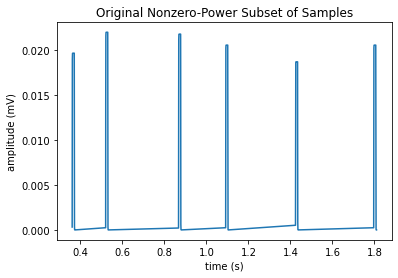

In [1151]:
# Plot original nonzero subset of samples
plt.title("Original Nonzero-Power Subset of Samples")
plt.plot(t[nonzero_indices], avg_power_nonzero)
plt.xlabel('time (s)')
plt.ylabel('amplitude (mV)')
plt.show()

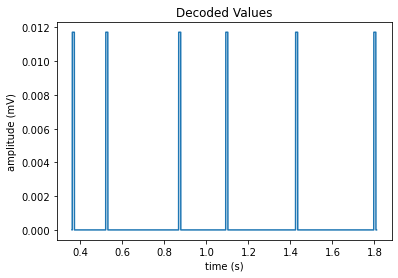

In [1152]:
# Plot decoded values
plt.title("Decoded Values")
plt.plot(t[nonzero_indices], decoded_values)
plt.xlabel('time (s)')
plt.ylabel('amplitude (mV)')
plt.show()

We can see that there are **different amplitude magnitudes** between the two signals, which can be attributed to the **unary encoding scheme**, where we take the *quotient* of each encoded value, rather than the value itself. 

Yet despite different values and scaling, we can see that the two plots (original nonzero power subset & decoded values) are similar in that **spikes are visible in both plots**, since spike-band mode **only cares about** signals that are **spikes**. 

This shows that our encoding/decoding method works well enough for our application.  